In [1]:
import torch
import os
import random
import utils
import data_utils
import json

import cbm
import plots

In [2]:
HOME="/home/jix049/private/"
# change this to the correct model dir, everything else should be taken care of
# load_dir = HOME+"saved_models/cub_lf_cbm"
load_dir = HOME+"saved_models/cifar10_cbm_manual_concepts"
# load_dir = "saved_models/cifar10_cbm_2024_10_16_16_01"
# load_dir="saved_models/cifar100_cbm_2024_10_16_17_02"
# load_dir="saved_models/cub_cbm_2024_10_20_19_48"
target_name="cifar_10_lf_cbm_manual_concepts"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

/home/jix049/private/Label-free-CBM/cbm.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  W_c = torch.load(os.path.join(load_dir ,"W_c.pt"), map_location=device)
/home/ji

In [3]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [9]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 40/40 [00:21<00:00,  1.83it/s]

Accuracy: 87.25%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [6]:
to_show = random.choices([i for i in range(len(classes))], k=1)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:174 - Pine Warbler
Incoming weights:
a white underparts [0.0984] Pine Warbler
a yellow upper tail [0.3163] Pine Warbler
a green upper tail [0.7523] Pine Warbler
an orange upper tail [0.3279] Pine Warbler
a white upper tail [0.0970] Pine Warbler
a red upper tail [0.3738] Pine Warbler
a crested head pattern [-0.1887] Pine Warbler
a red breast [0.1559] Pine Warbler
a brown throat [-0.0576] Pine Warbler
a grey throat [-0.3205] Pine Warbler
a blue eye [0.2084] Pine Warbler
an iridescent under tail [-0.3451] Pine Warbler
a grey nape [-0.1225] Pine Warbler
a long-wings shape [-0.1445] Pine Warbler
a sandpiper-like shape [0.0760] Pine Warbler
a swallow-like shape [-0.8170] Pine Warbler
a spotted tail pattern [-0.1513] Pine Warbler
a grey primary color [-0.1825] Pine Warbler
an olive primary color [0.3482] Pine Warbler
a green primary color [0.1676] Pine Warbler
an orange primary color [0.2326] Pine Warbler
an iridescent leg [0.1759] Pine Warbler
a yellow leg [0.4280] Pine Warbler


In [7]:
to_show = random.choices([i for i in range(len(concepts))], k=1)
to_show = [99]

for i in to_show:
    print("concept:{} - {}".format(i, concepts[i]))
    print("Outgoing weights:")
    for j in range(len(classes)):
        if torch.abs(model.final.weight[j,i])>0.05:
            print("{} [{:.4f}] {}".format(concepts[i], model.final.weight[j,i], classes[j]))

concept:99 - a grey nape
Outgoing weights:
a grey nape [0.1496] Least Auklet
a grey nape [0.1237] Parakeet Auklet
a grey nape [-0.1510] Indigo Bunting
a grey nape [-0.5454] American Crow
a grey nape [0.0603] Mangrove Cuckoo
a grey nape [0.0571] Purple Finch
a grey nape [0.4021] Olive sided Flycatcher
a grey nape [-0.1055] Frigatebird
a grey nape [0.2877] Eared Grebe
a grey nape [0.3591] Horned Grebe
a grey nape [0.0926] Pied billed Grebe
a grey nape [-0.2483] Evening Grosbeak
a grey nape [-0.1700] Rufous Hummingbird
a grey nape [-0.0701] Blue Jay
a grey nape [0.0528] Florida Jay
a grey nape [0.2835] Gray Kingbird
a grey nape [-0.2438] White breasted Kingfisher
a grey nape [-0.1058] Baltimore Oriole
a grey nape [0.3559] Western Wood Pewee
a grey nape [0.1077] Brewer Sparrow
a grey nape [0.0769] Henslow Sparrow
a grey nape [0.4368] Nelson Sharp tailed Sparrow
a grey nape [-0.1529] Summer Tanager
a grey nape [0.2946] Black throated Blue Warbler
a grey nape [0.2099] Nashville Warbler
a gre

In [8]:
# Count negative and positive weights for each feature
negative_counts = torch.sum(model.final.weight < -0.05, dim=0)
positive_counts = torch.sum(model.final.weight > 0.05, dim=0)

# Calculate the ratio of negative to positive weights
# Adding a small epsilon to avoid division by zero
epsilon = 1e-10
negative_to_positive_ratio = negative_counts / (positive_counts + epsilon)

# Find the feature (index) with the highest negative to positive ratio
feature_with_highest_ratio = torch.argmax(negative_to_positive_ratio).item()

# Get the actual ratio for this feature
max_ratio = negative_to_positive_ratio[feature_with_highest_ratio].item()

# Get counts for the feature with the highest ratio
feature_negative_count = negative_counts[feature_with_highest_ratio].item()
feature_positive_count = positive_counts[feature_with_highest_ratio].item()
total_weights = model.final.weight.shape[0]

print(f"Feature {feature_with_highest_ratio} has the highest ratio of negative to positive weights.")
print(f"Negative to positive ratio: {max_ratio:.2f}")
print(f"It has {feature_negative_count} negative weights and {feature_positive_count} positive weights")
print(f"out of {total_weights} total incoming weights.")

# Calculate percentages
negative_percentage = (feature_negative_count / total_weights) * 100
positive_percentage = (feature_positive_count / total_weights) * 100

print(f"Negative weights represent {negative_percentage:.2f}% of its incoming weights.")
print(f"Positive weights represent {positive_percentage:.2f}% of its incoming weights.")

Feature 47 has the highest ratio of negative to positive weights.
Negative to positive ratio: 1.75
It has 14 negative weights and 8 positive weights
out of 200 total incoming weights.
Negative weights represent 7.00% of its incoming weights.
Positive weights represent 4.00% of its incoming weights.


In [15]:
total_sum = torch.sum(model.final.weight).item()

print(f"The sum of all weights in model.final.weight is: {total_sum}")

# Assuming model.final.weight is a PyTorch tensor
positive_count = torch.sum(model.final.weight > 0).item()
negative_count = torch.sum(model.final.weight < 0).item()
zero_count = torch.sum(model.final.weight == 0).item()

total_weights = model.final.weight.numel()

print(f"Positive weights: {positive_count}")
print(f"Negative weights: {negative_count}")
print(f"Zero weights: {zero_count}")
print(f"Total weights: {total_weights}")

The sum of all weights in model.final.weight is: 414.9124755859375
Positive weights: 3695
Negative weights: 2426
Zero weights: 28479
Total weights: 34600


In [9]:
# to_show = random.choices([i for i in range(len(classes))], k=2)
to_show = [44]

top_weights, top_weight_ids = torch.topk(model.final.weight, k=10, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=10, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 44 - Northern Fulmar
Highest weights: a purple belly:0.575, a grey wing:0.323, a duck-like shape:0.297, a white belly:0.263, a blue breast:0.229, an owl-like shape:0.224, a blue upper tail:0.184, a brown under tail:0.179, a brown underparts:0.174, a black back:0.172, 
Lowest weights: a pink primary color:-1.039, a black primary color:-0.510, a purple throat:-0.485, a blue throat:-0.369, a brown primary color:-0.361, a brown throat:-0.141, a pink bill:-0.102, a red primary color:-0.054, a rufous primary color:-0.002, a hooked seabird bill:0.000, 



In [13]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:173/173


## Explain model reasoning for random inputs

In [10]:
from IPython.display import display, HTML

display(HTML('''
    <script>
        IPython.OutputArea.prototype._should_scroll = function(lines) {
            return false;
        }
    </script>
    <style>
        .output_wrapper, .output {
            height:auto !important;
            max-height:none;
        }
        .output_scroll {
            box-shadow:none !important;
            webkit-box-shadow:none !important;
        }
    </style>
'''))

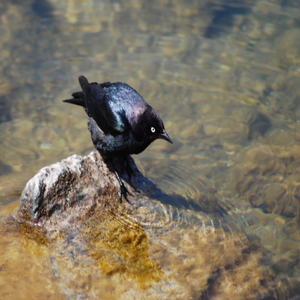

Image:187 Gt:Brewer Blackbird, 1st Pred:Brewer Blackbird, 6.896, 2nd Pred:Common Raven, 5.331


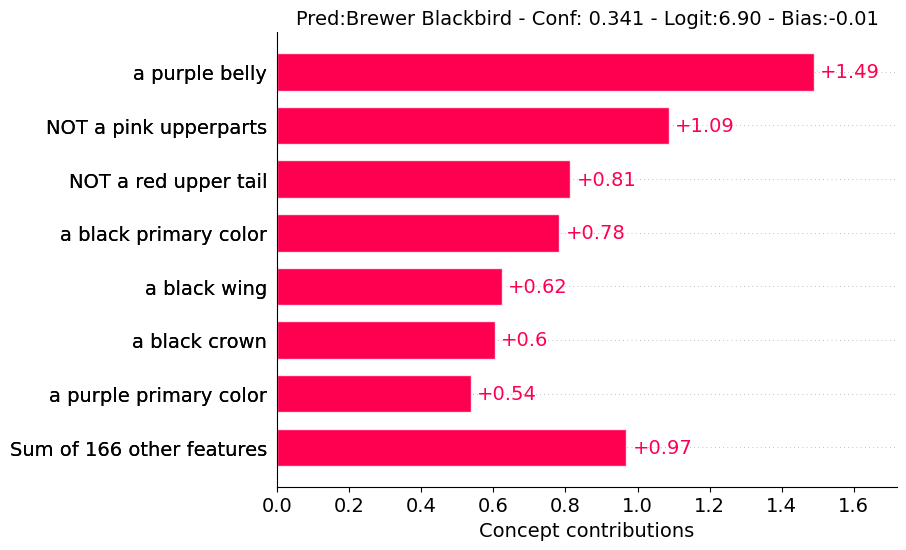

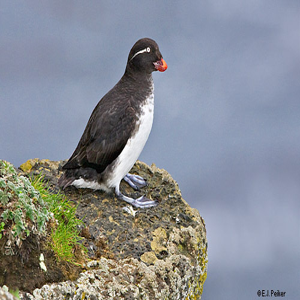

Image:152 Gt:Parakeet Auklet, 1st Pred:Parakeet Auklet, 9.909, 2nd Pred:Least Auklet, 6.166


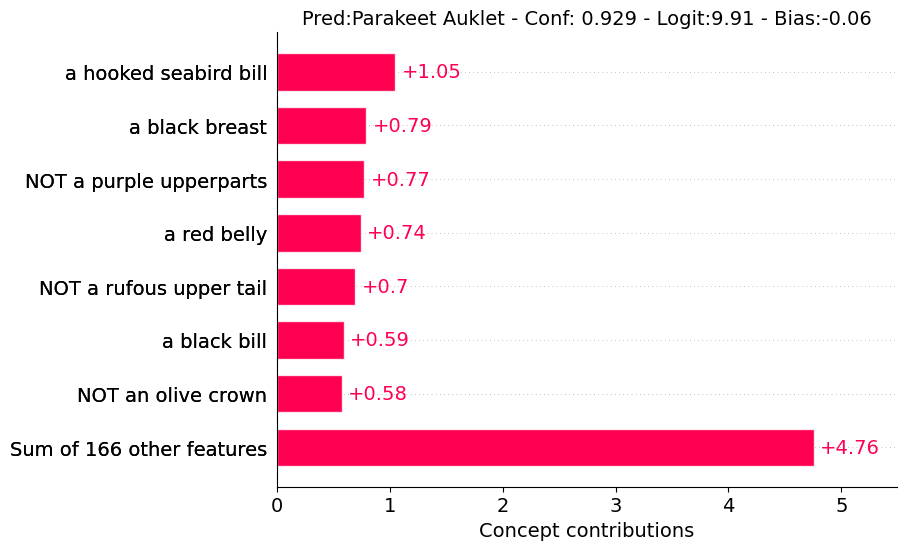

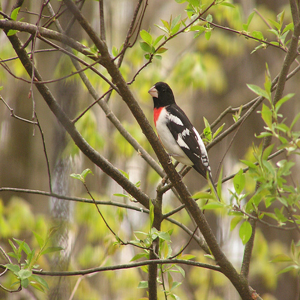

Image:1580 Gt:Rose breasted Grosbeak, 1st Pred:Rose breasted Grosbeak, 7.685, 2nd Pred:Red winged Blackbird, 5.721


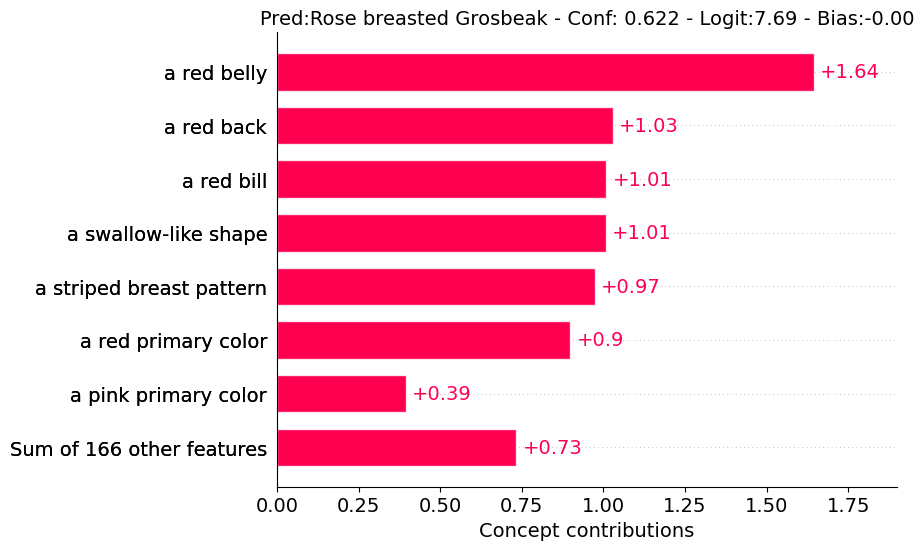

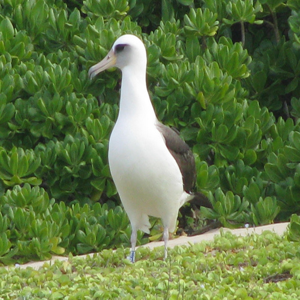

Image:58 Gt:Laysan Albatross, 1st Pred:Laysan Albatross, 7.426, 2nd Pred:California Gull, 4.789


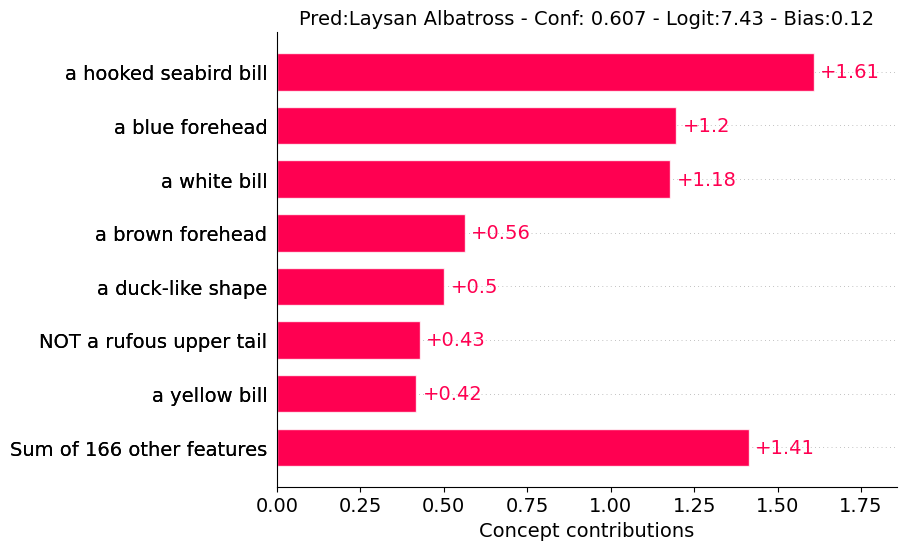

In [12]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)
# to_display=range(0,5,1)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([300,300]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=14)
            

Image:0 Gt:cat, 1st Pred:frog, 4.532, 2nd Pred:cat, 3.811


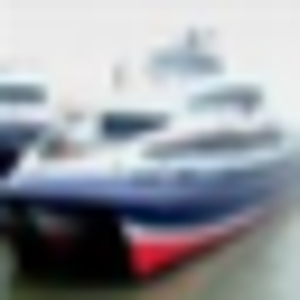

Image:1 Gt:ship, 1st Pred:ship, 8.451, 2nd Pred:airplane, 5.038


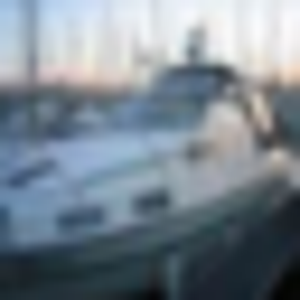

Image:2 Gt:ship, 1st Pred:ship, 9.599, 2nd Pred:automobile, 4.057


Image:3 Gt:airplane, 1st Pred:airplane, 5.877, 2nd Pred:ship, 4.512


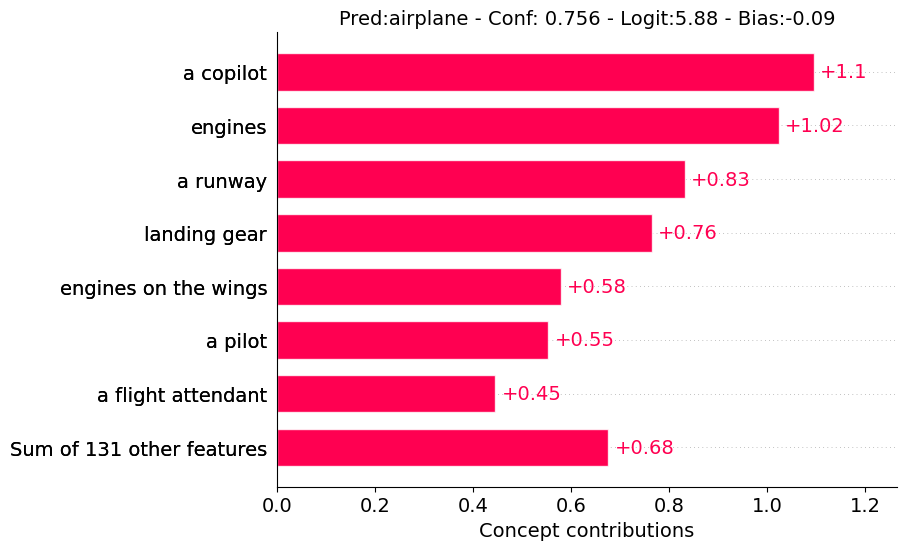

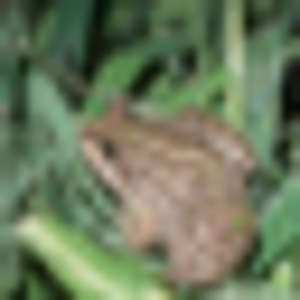

Image:4 Gt:frog, 1st Pred:frog, 8.890, 2nd Pred:bird, 4.260


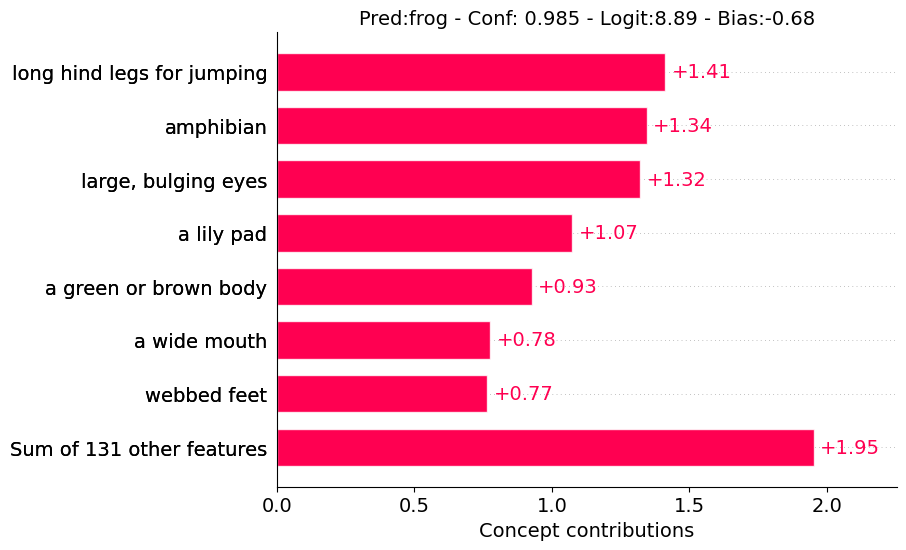

In [25]:
# to_display = random.sample([i for i in range(len(val_pil_data))], k=4)
to_display=range(0,5,1)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([300,300]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=14)

## show highest activation for neuron

In [20]:
import linear_explanation as le
import pandas as pd
import math
import matplotlib.pyplot as plt

In [21]:
target_name = "cifar10_cbm_manual_concepts_acc" #"cifar10_lf_cbm"
dataset_name = "cifar10"
target_layer = "proj_layer"
save_dir = 'saved_activations'
save_path = '{}/{}_{}/{}/'.format(save_dir, target_name, dataset_name, target_layer)
device = "cuda"
batch_size=128
pool_mode = "avg"#"avg"#"first"
dataset=val_data_t
true_concepts=concepts

In [27]:
def plot_images(images, axs):
    """
    images: list
    """
    
    for i, top_id in enumerate(images):
        #normalize to 0-1 range
#         if activations != None:
#             curr_act = activations[top_id]
#             curr_act -= curr_act.min()
#             curr_act /= curr_act.max()
#             mask = curr_act.unsqueeze(0)
#         else:
#             mask = torch.ones((1, 1, 1))
                    
        x, label = val_pil_data[top_id]
        axs[i].imshow(x)
        axs[i].axis('off')

In [28]:
target_neurons=range(0,20,1)

Neuron 0 - a barn


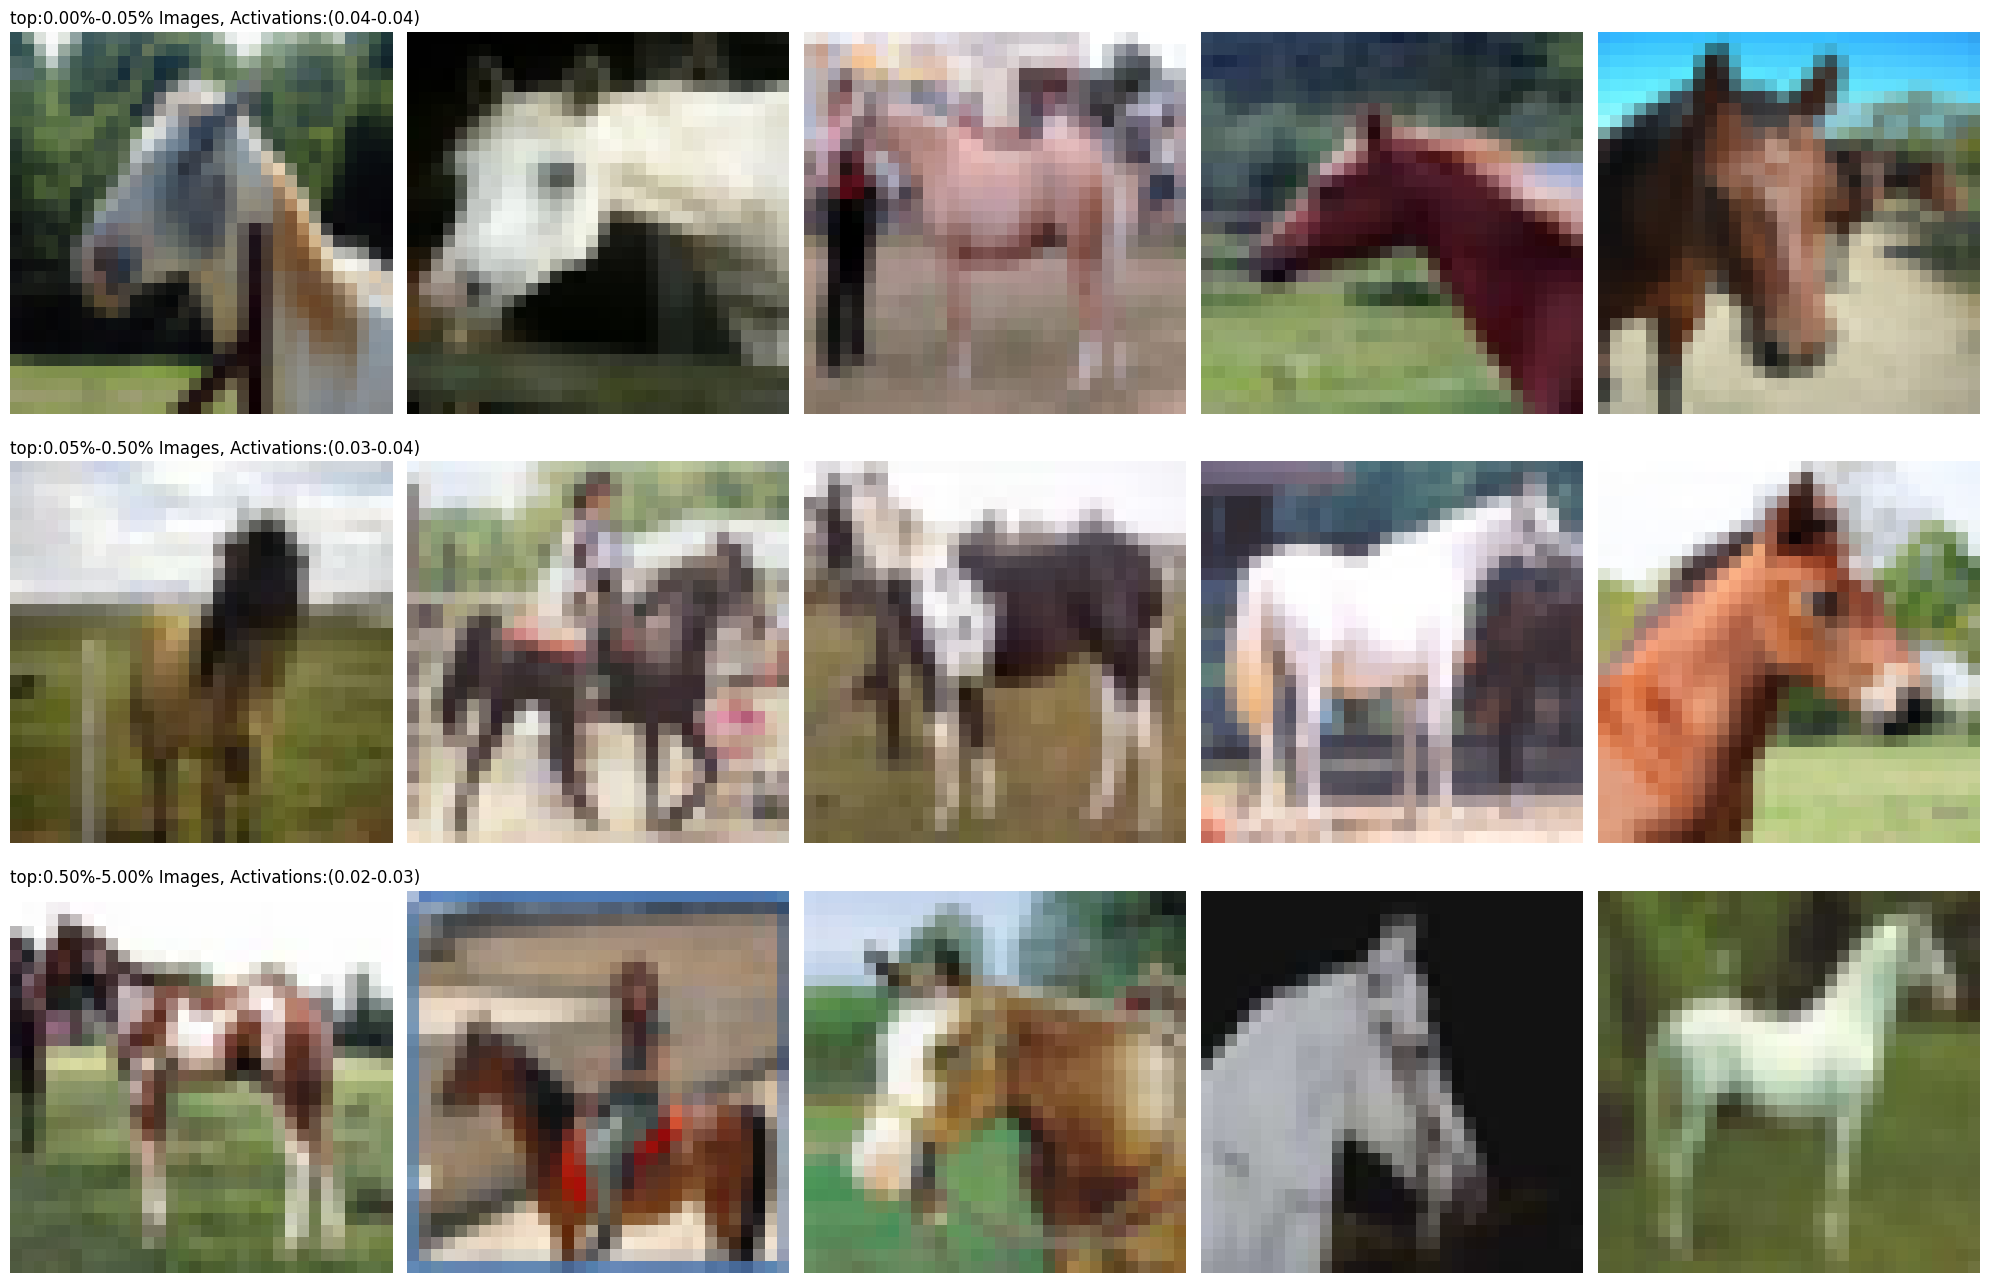

Neuron 1 - a beak


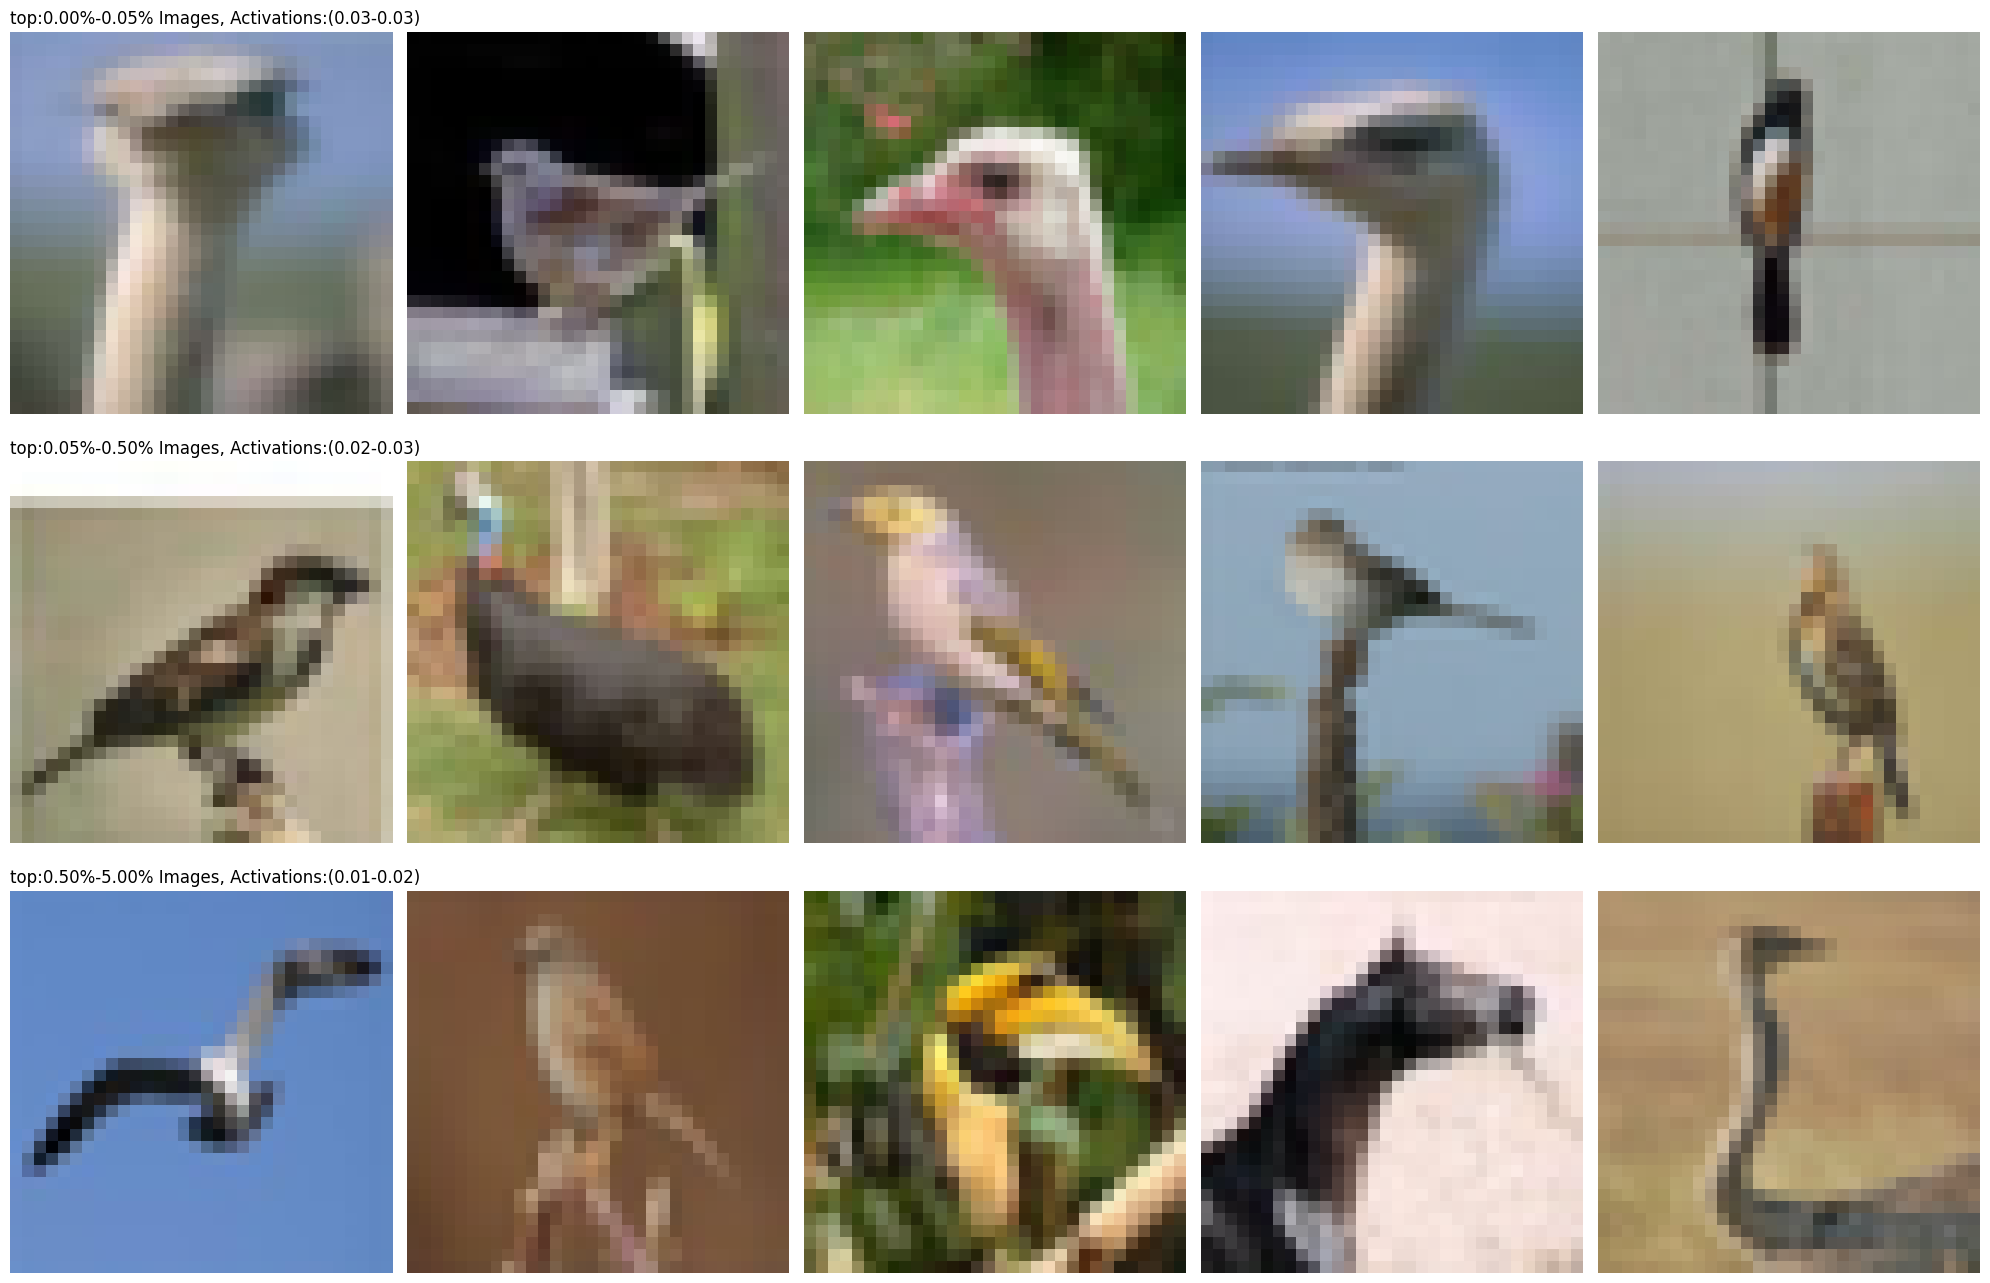

Neuron 2 - a cargo bed


Neuron 3 - a birdfeeder


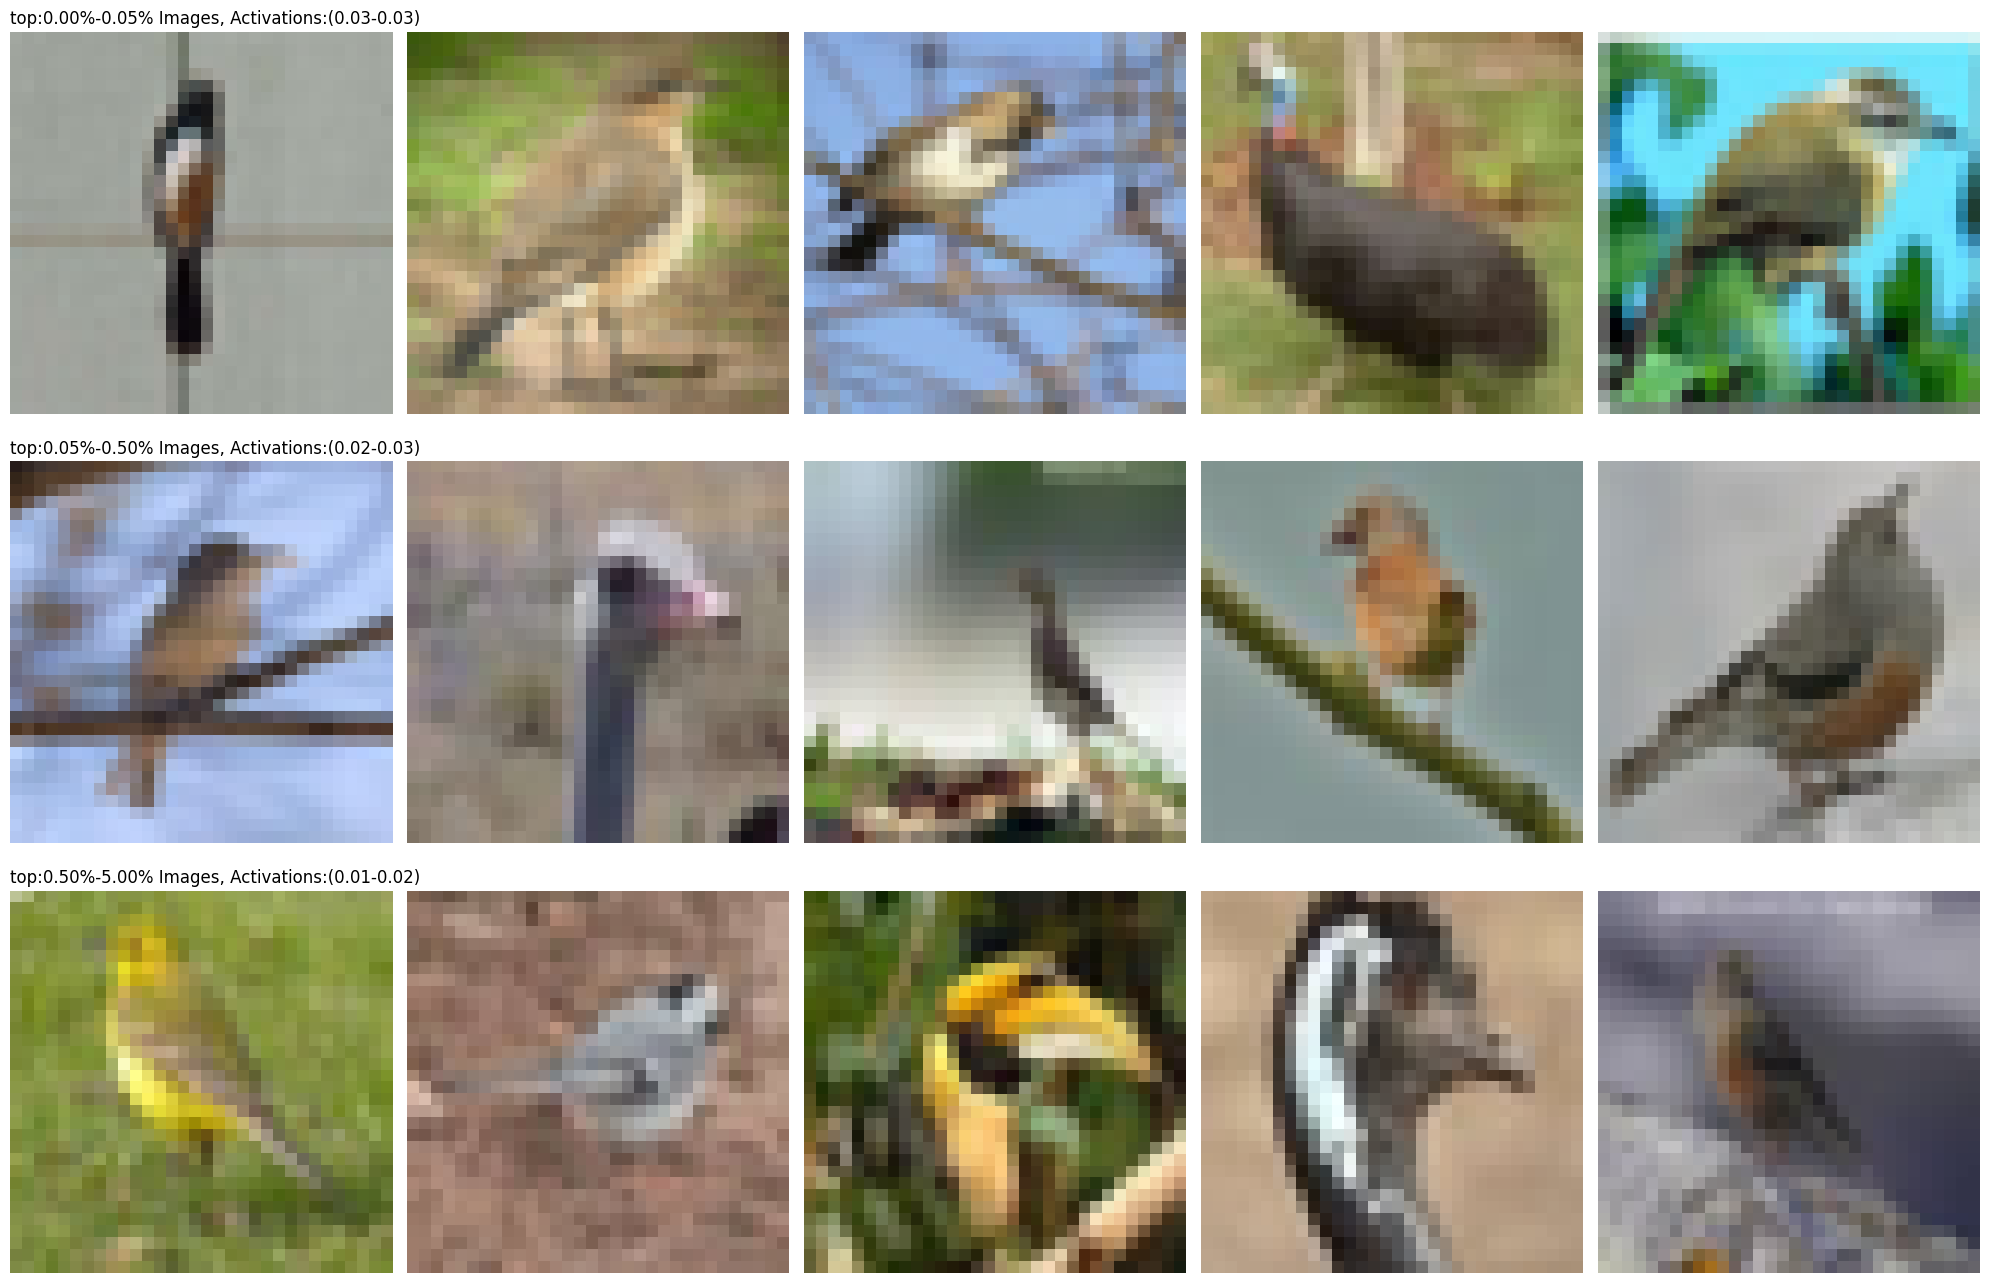

Neuron 4 - a boat


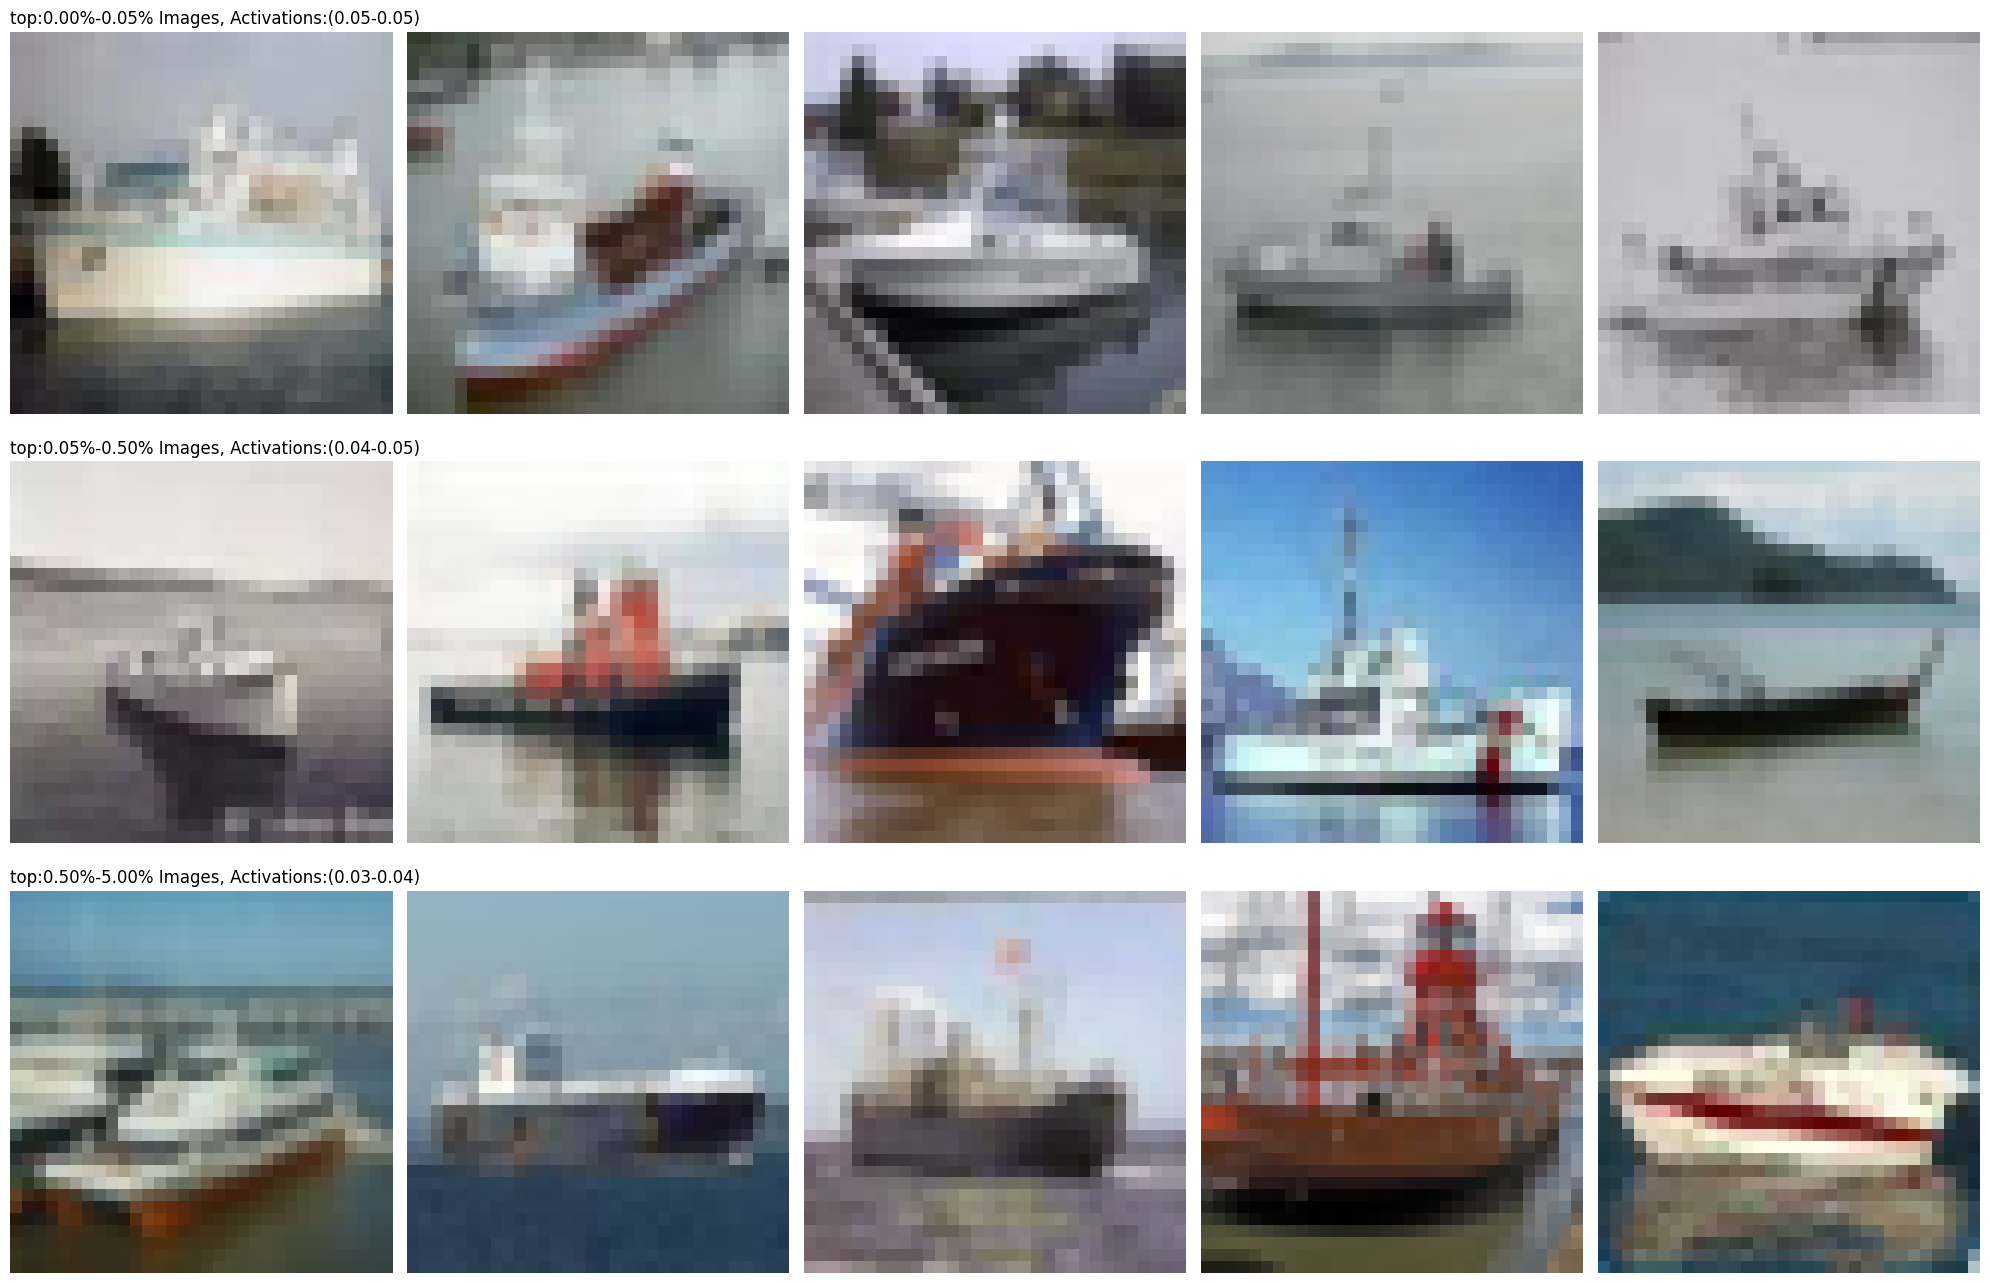

Neuron 5 - a branch


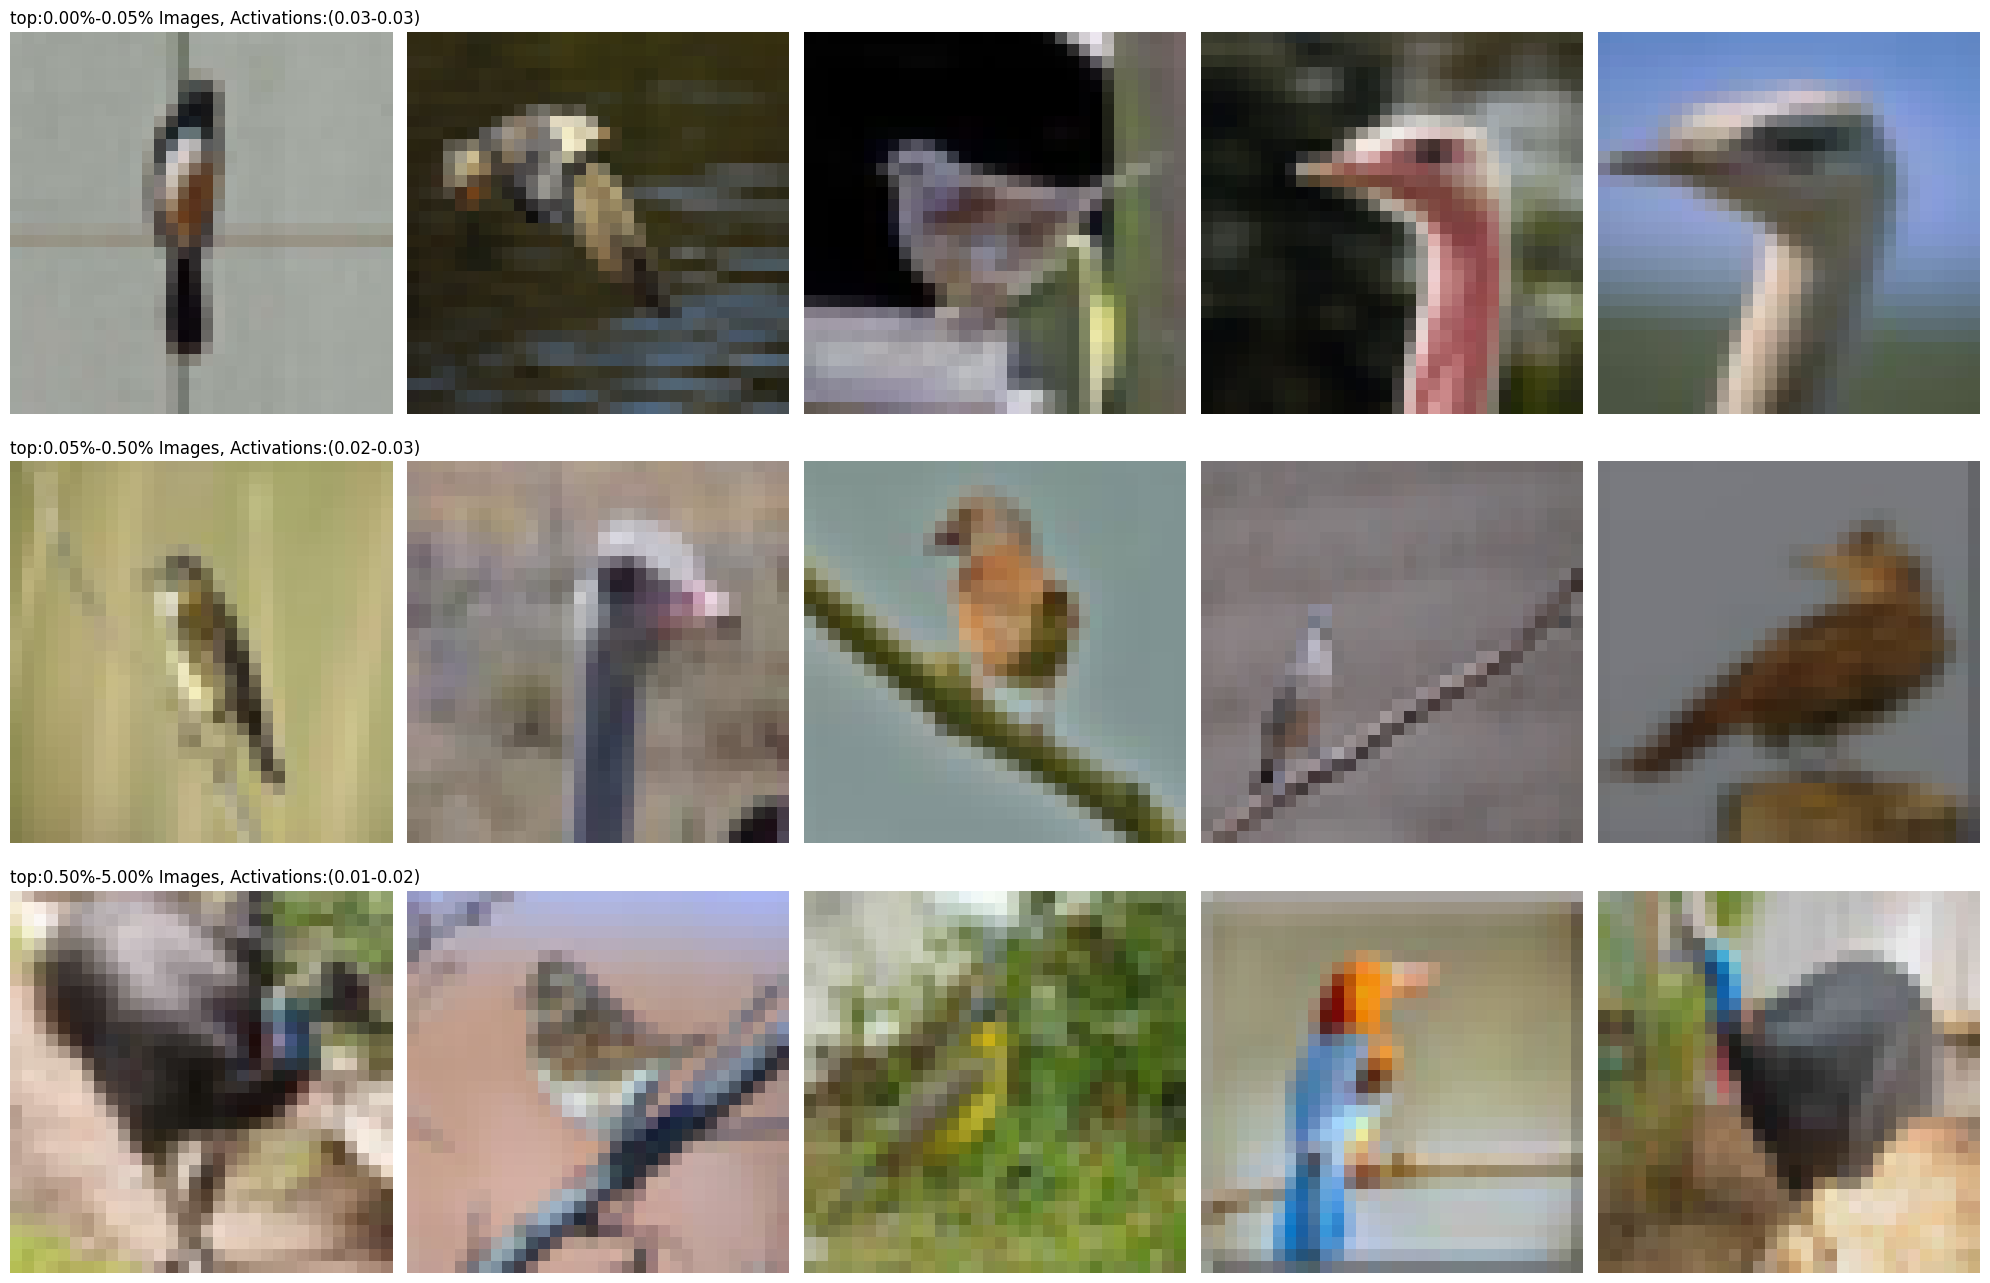

Neuron 6 - a bridle


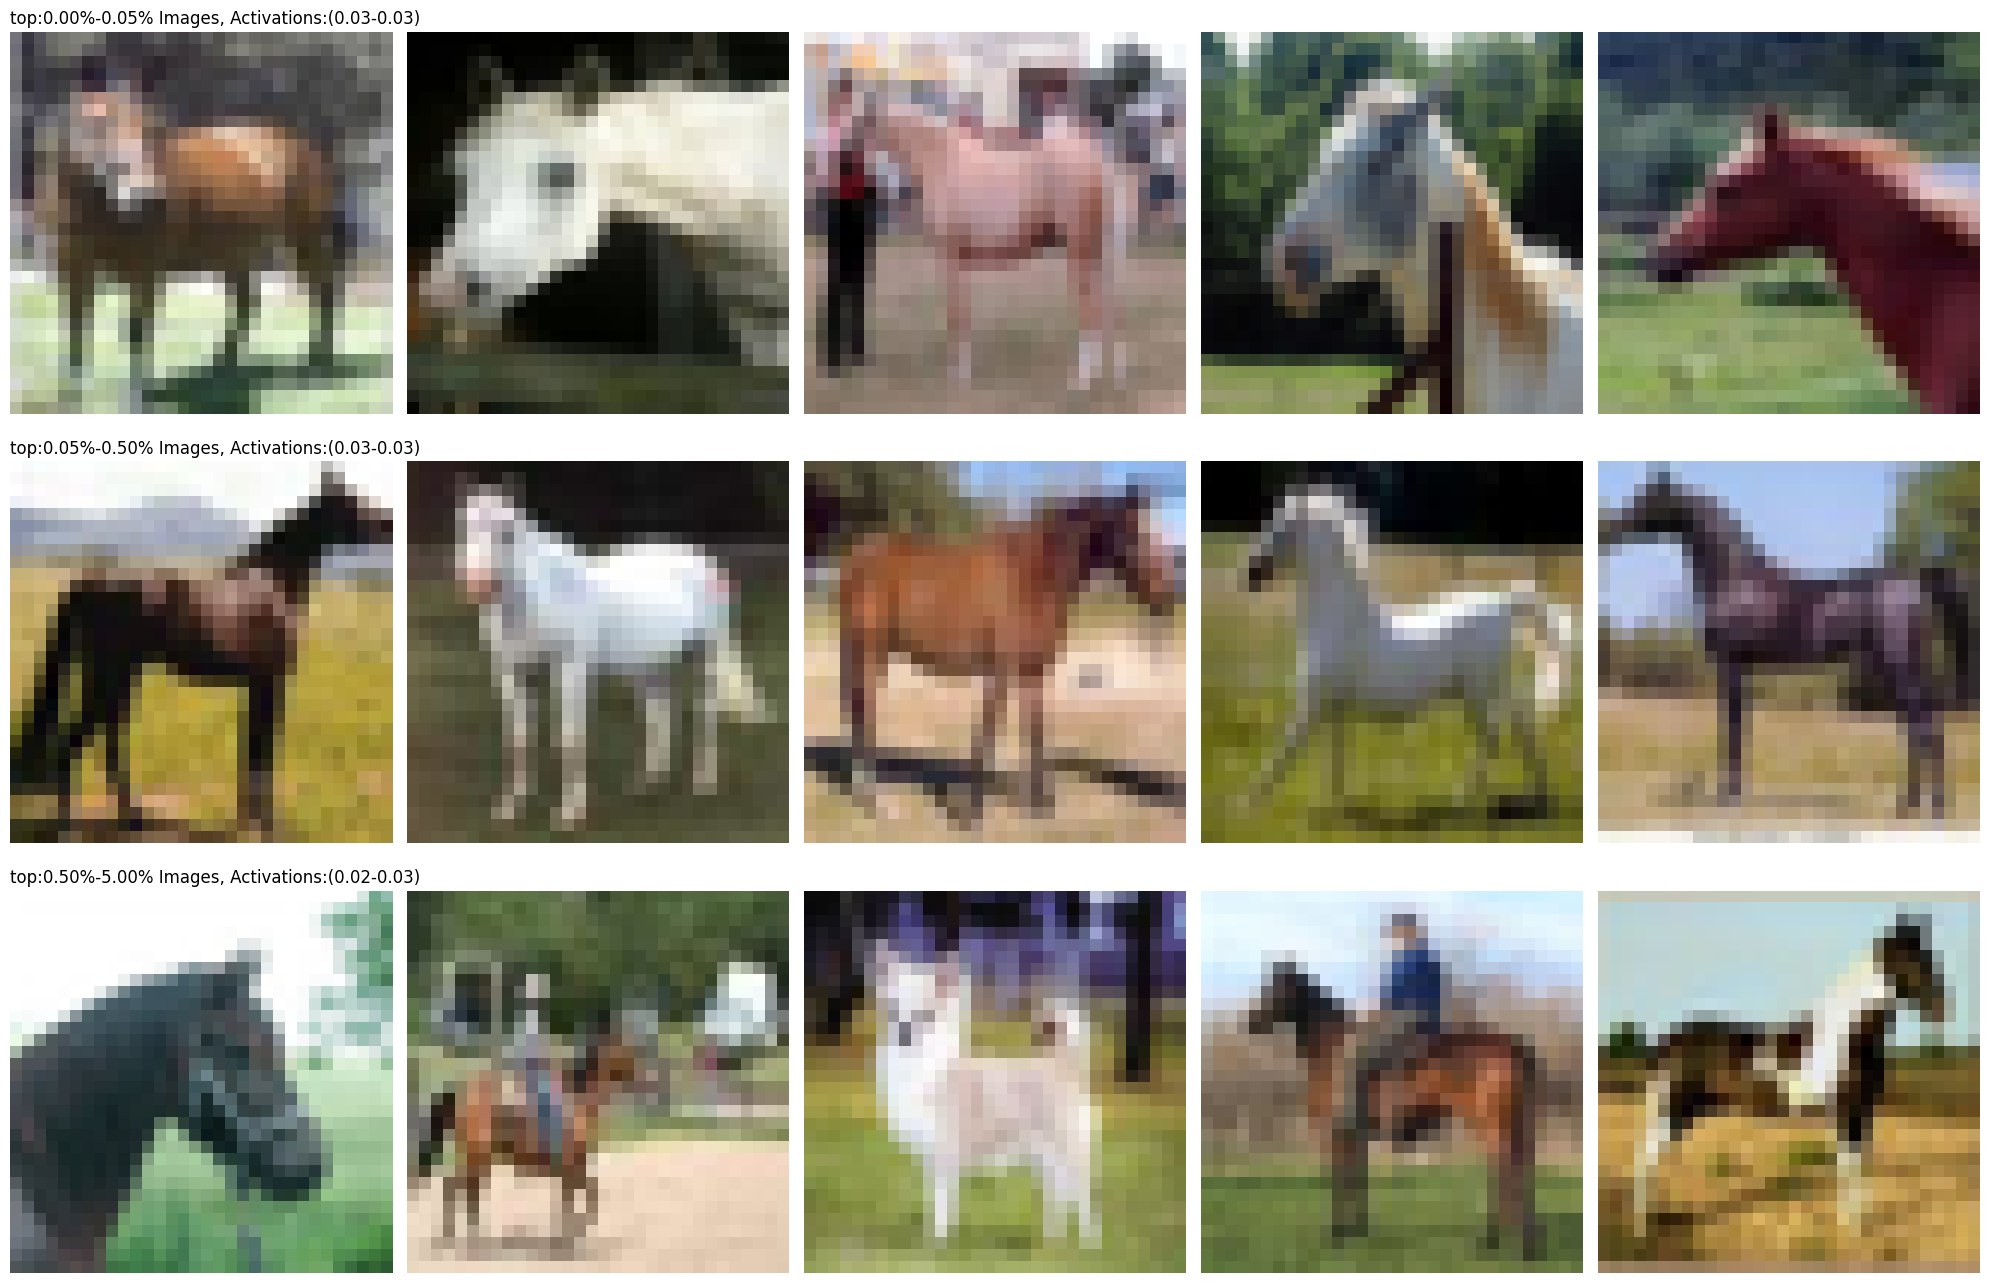

Neuron 7 - a cab for the driver


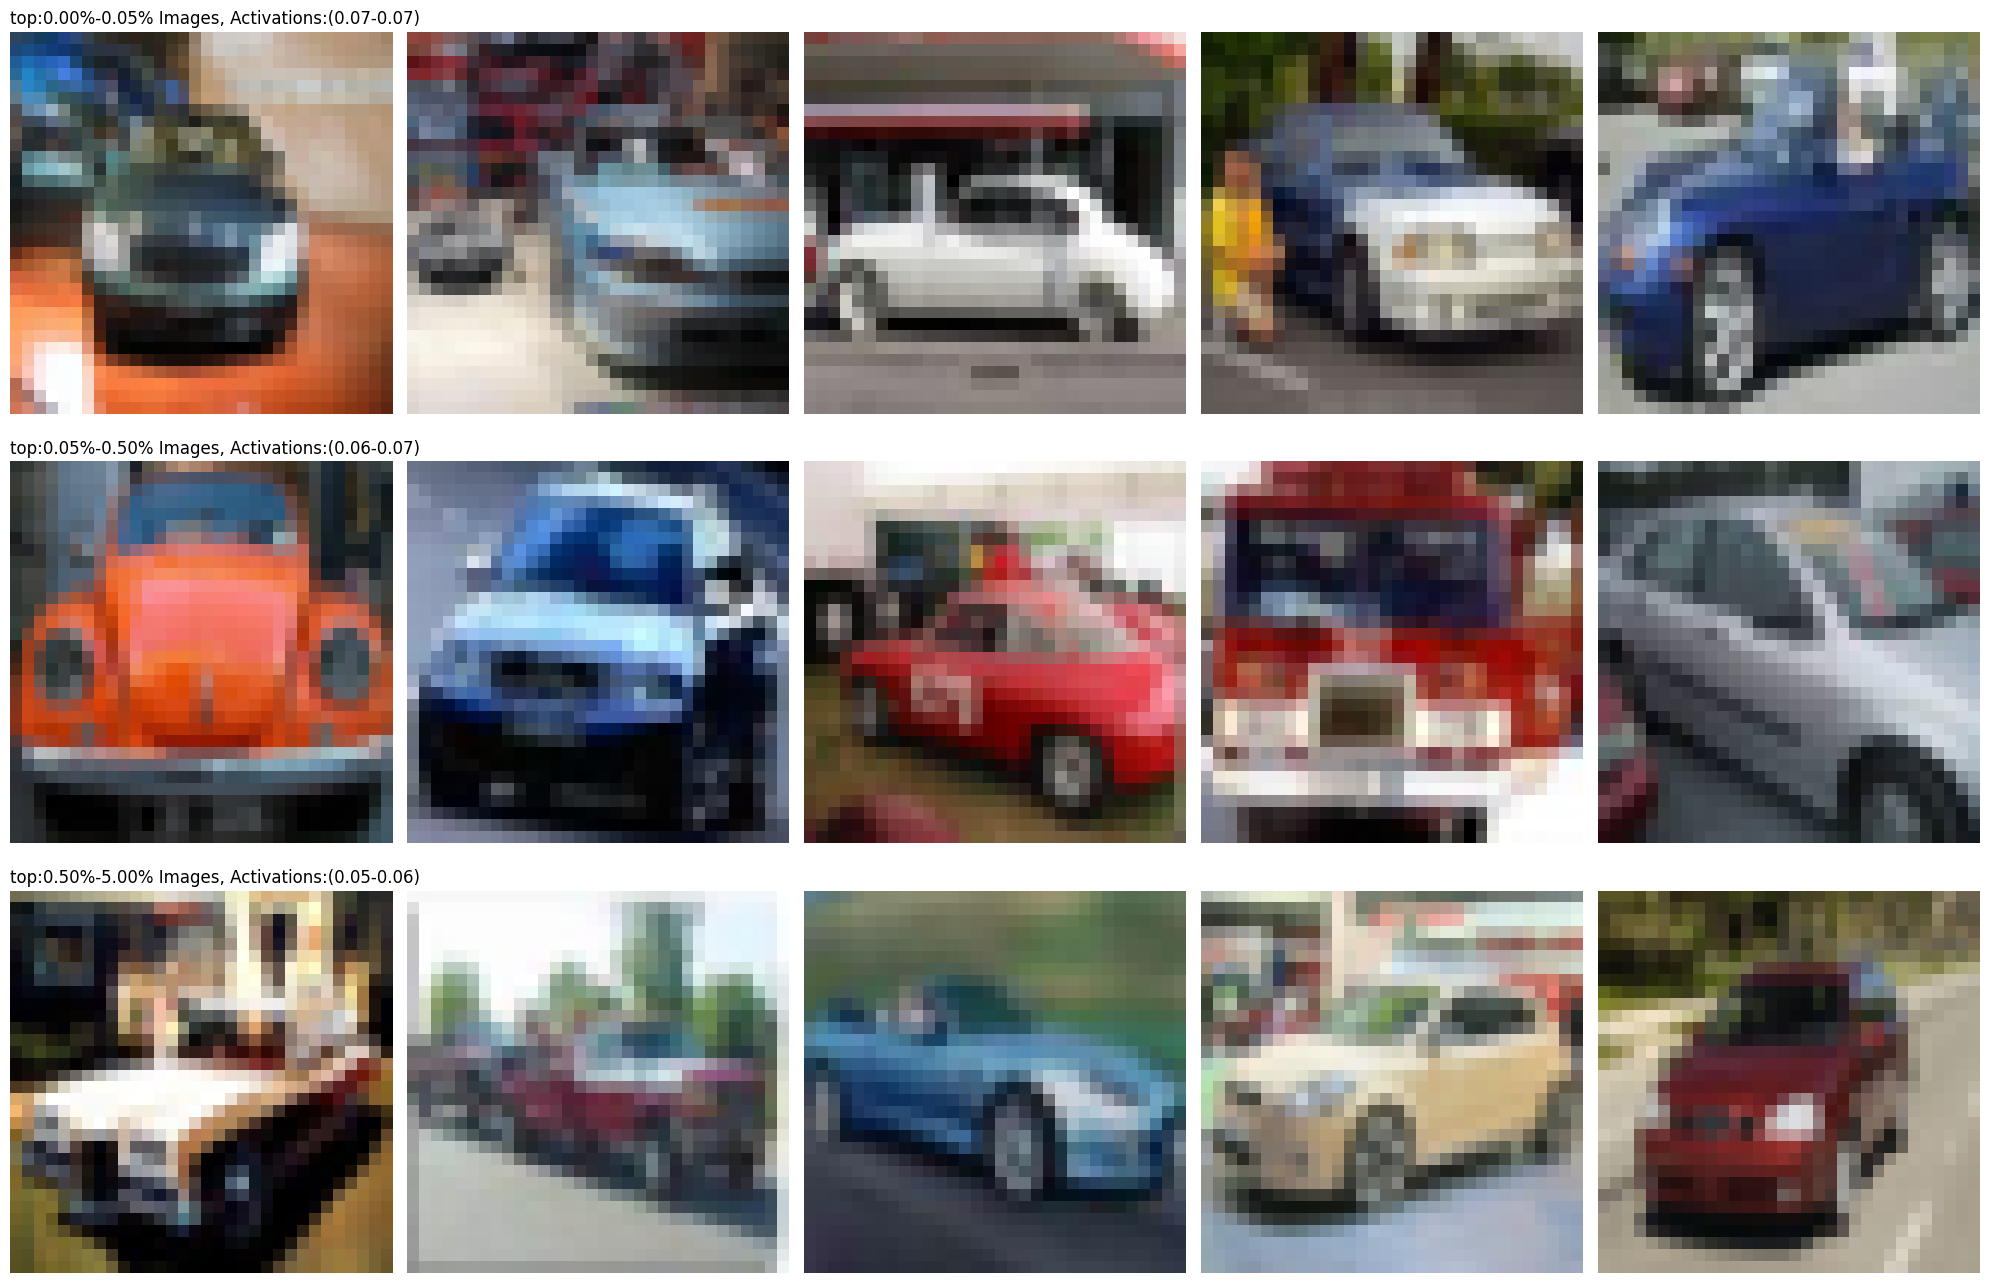

Neuron 8 - a cage


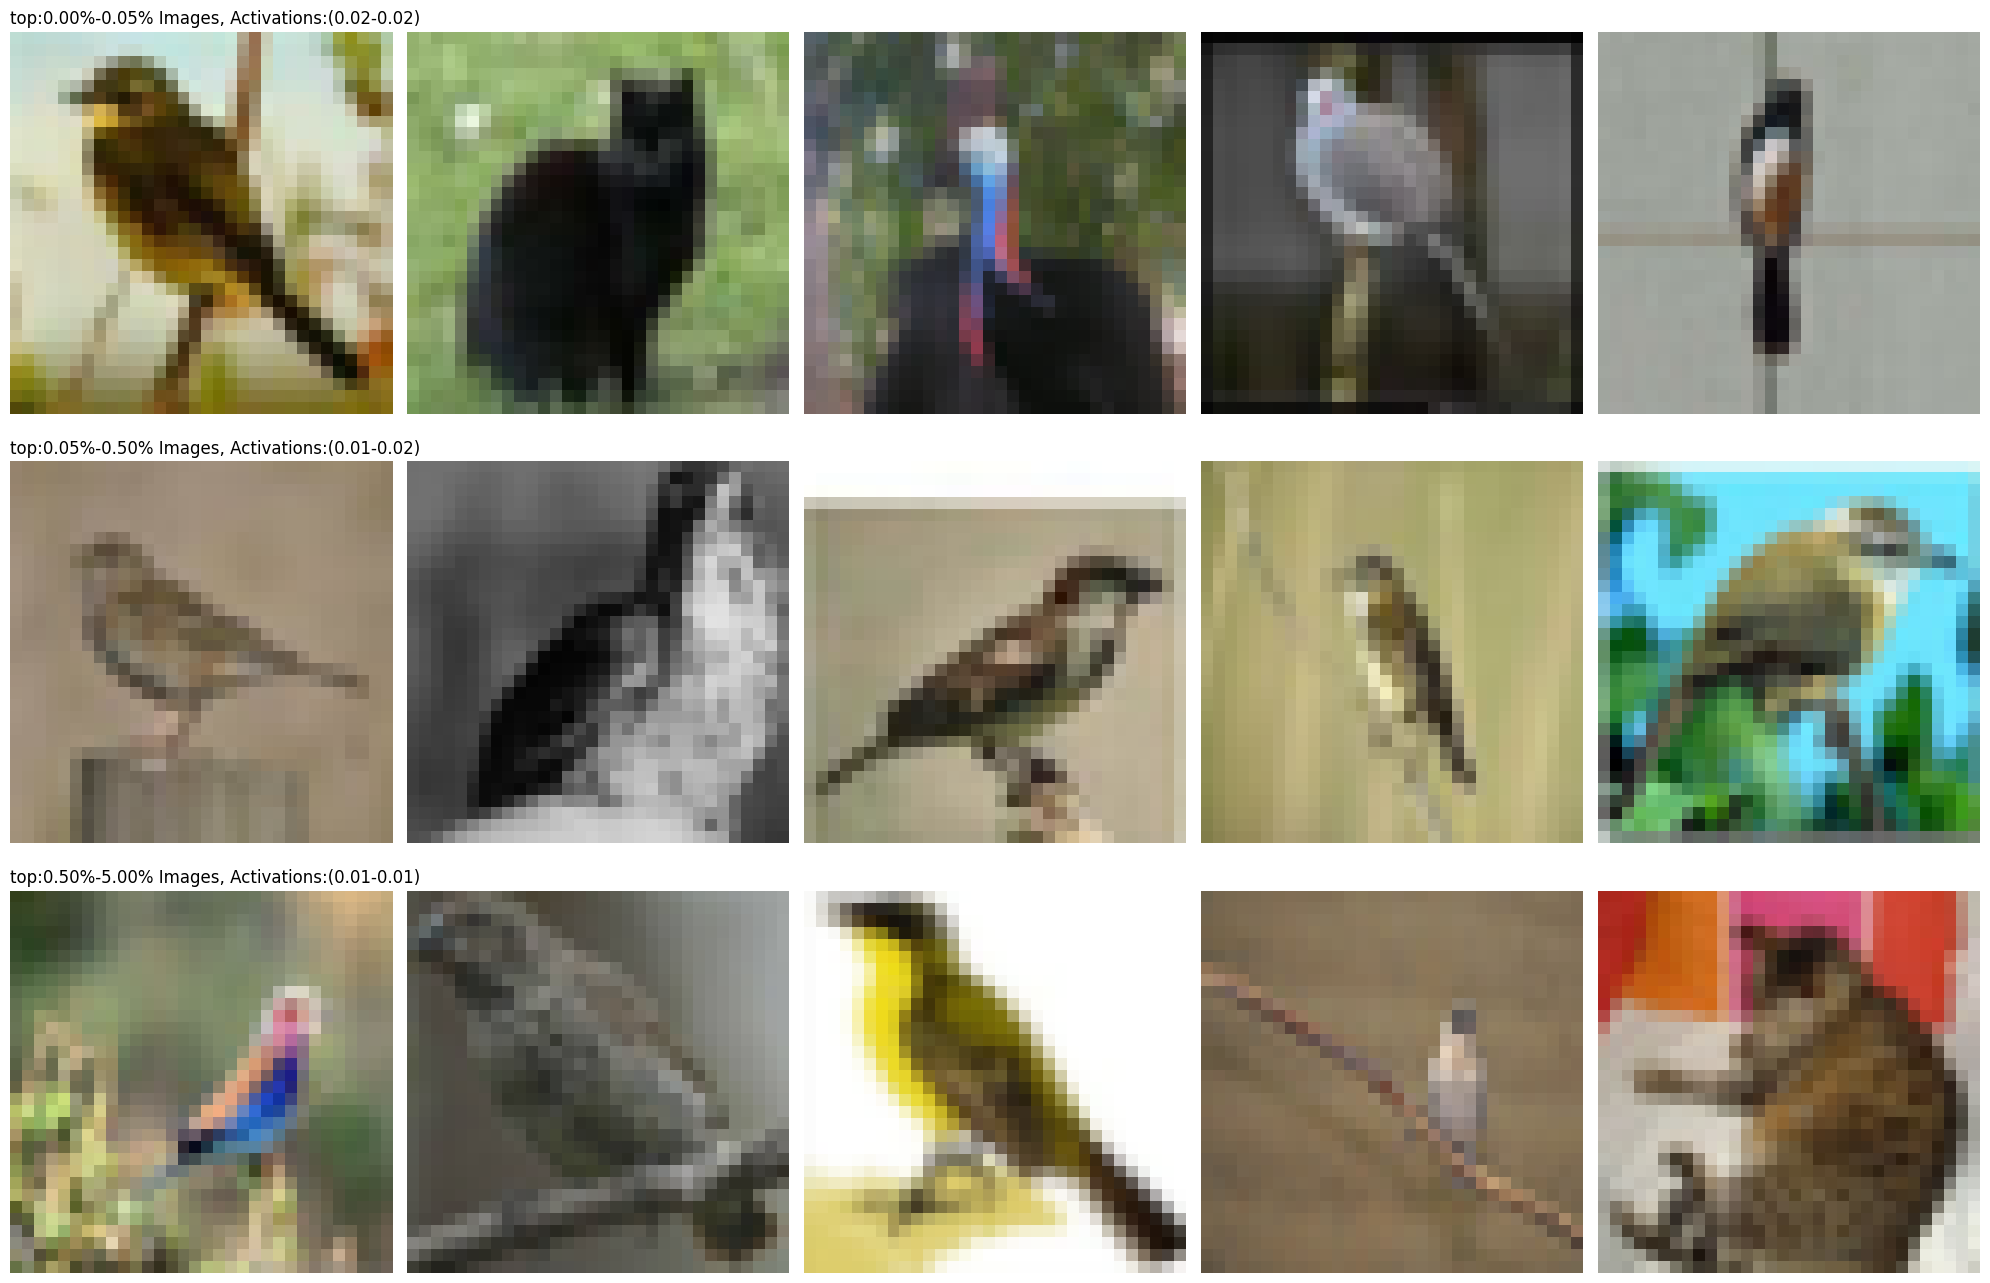

Neuron 9 - a captain


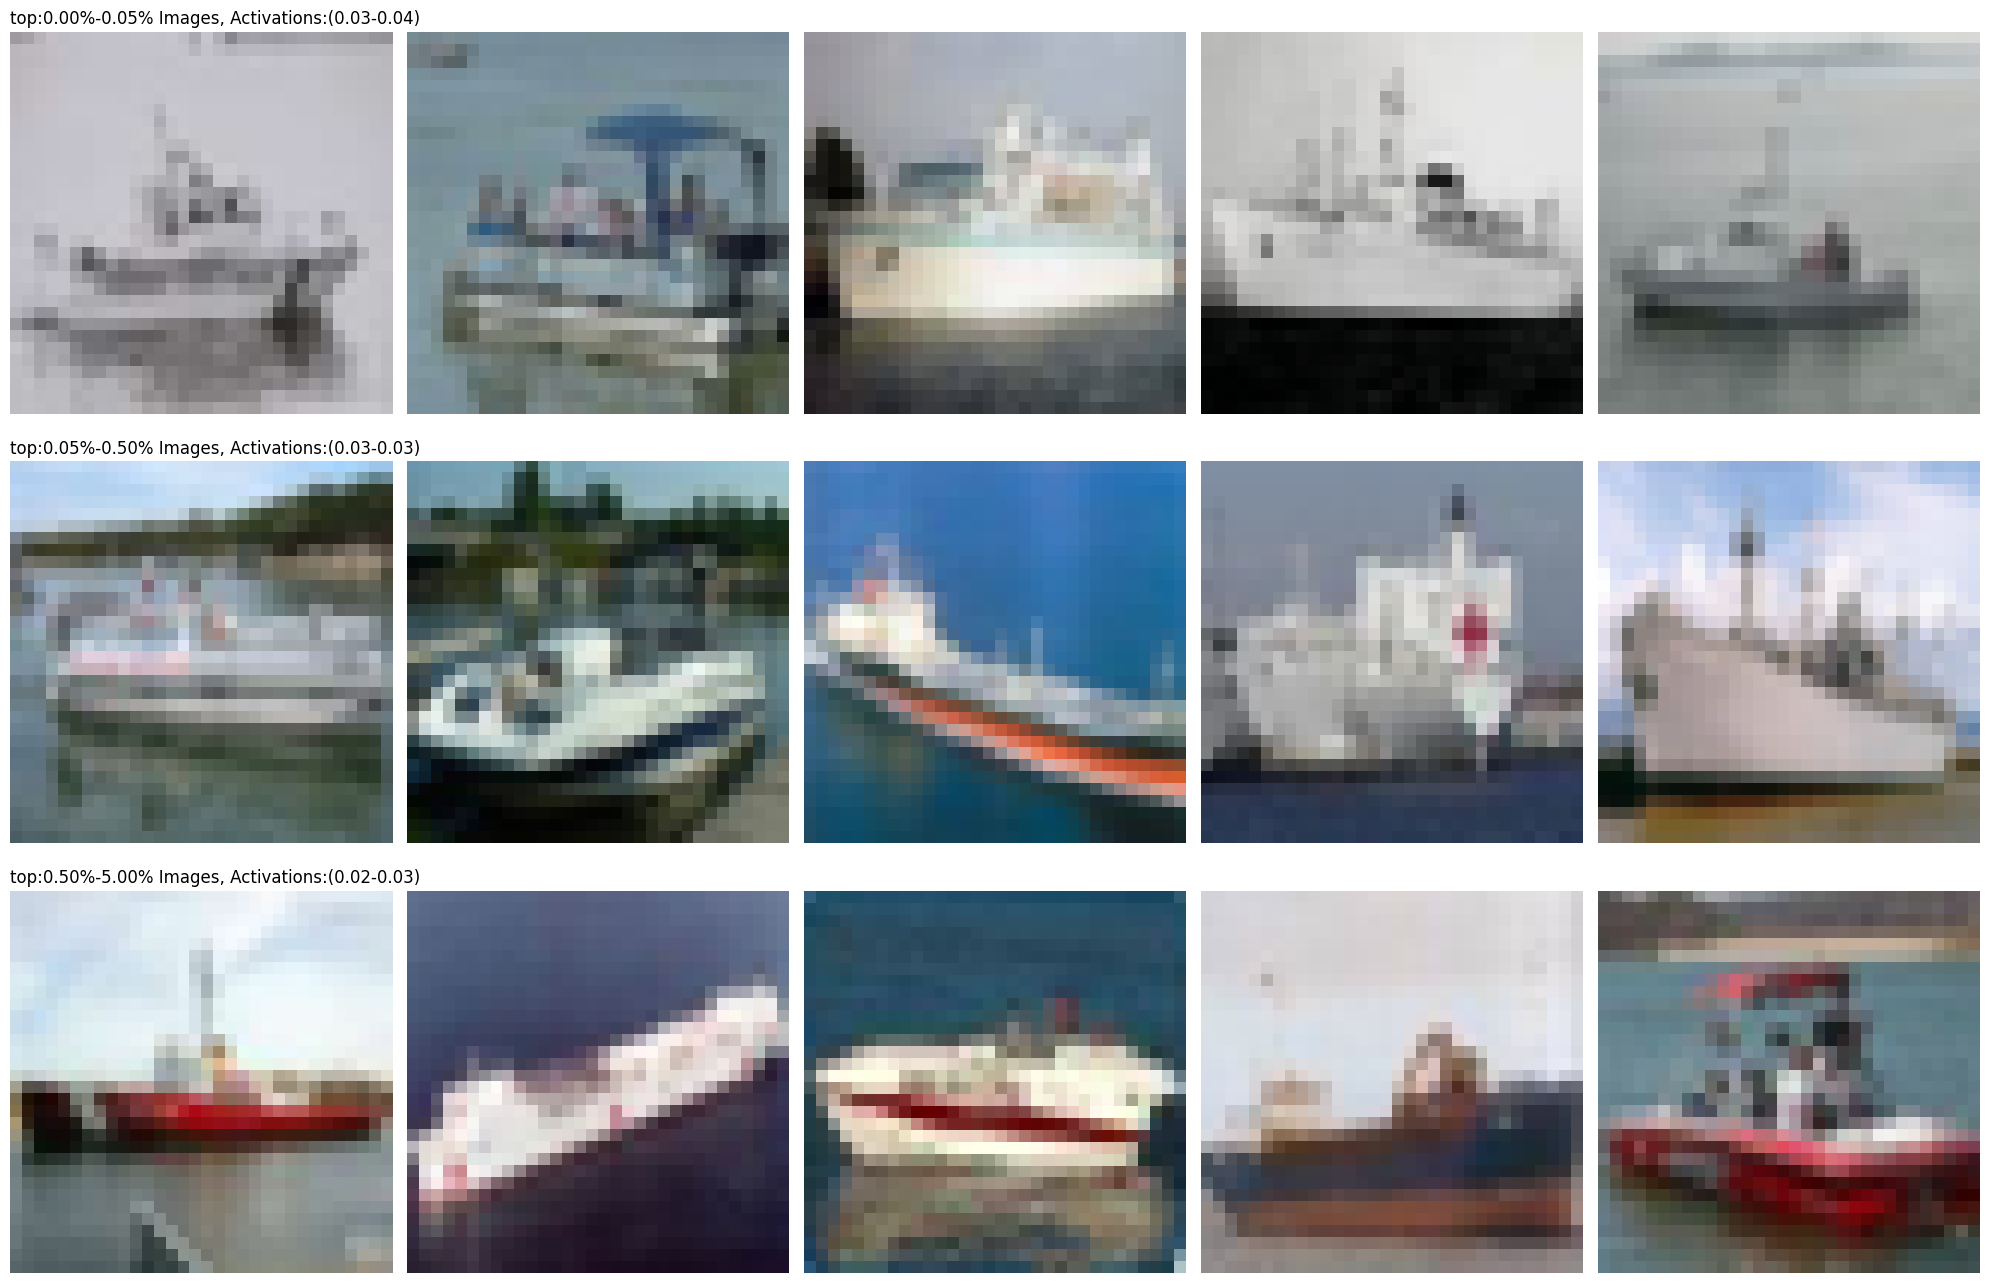

Neuron 10 - a brown body


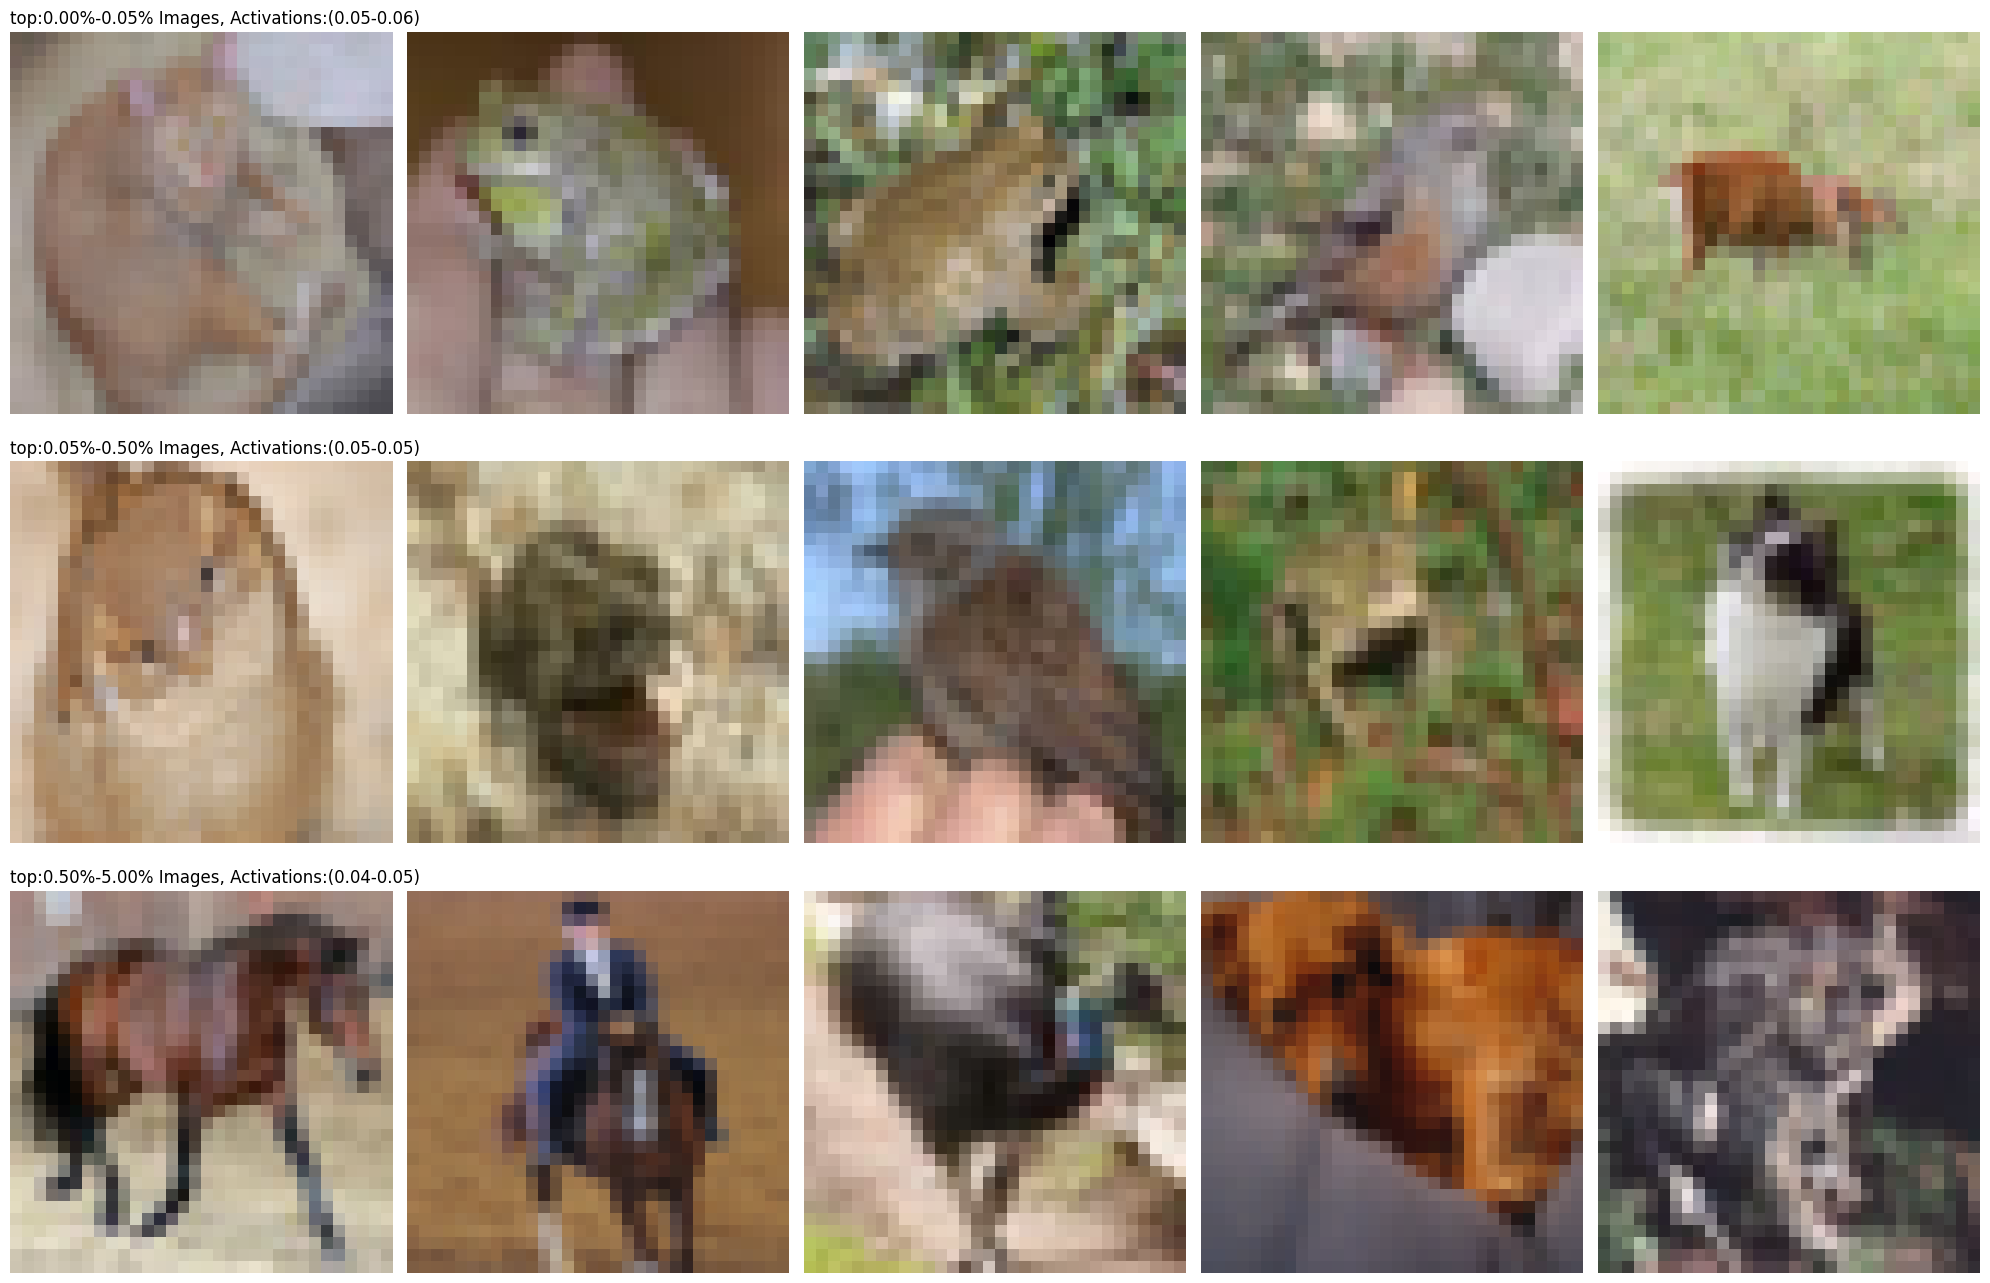

Neuron 11 - a cat bed


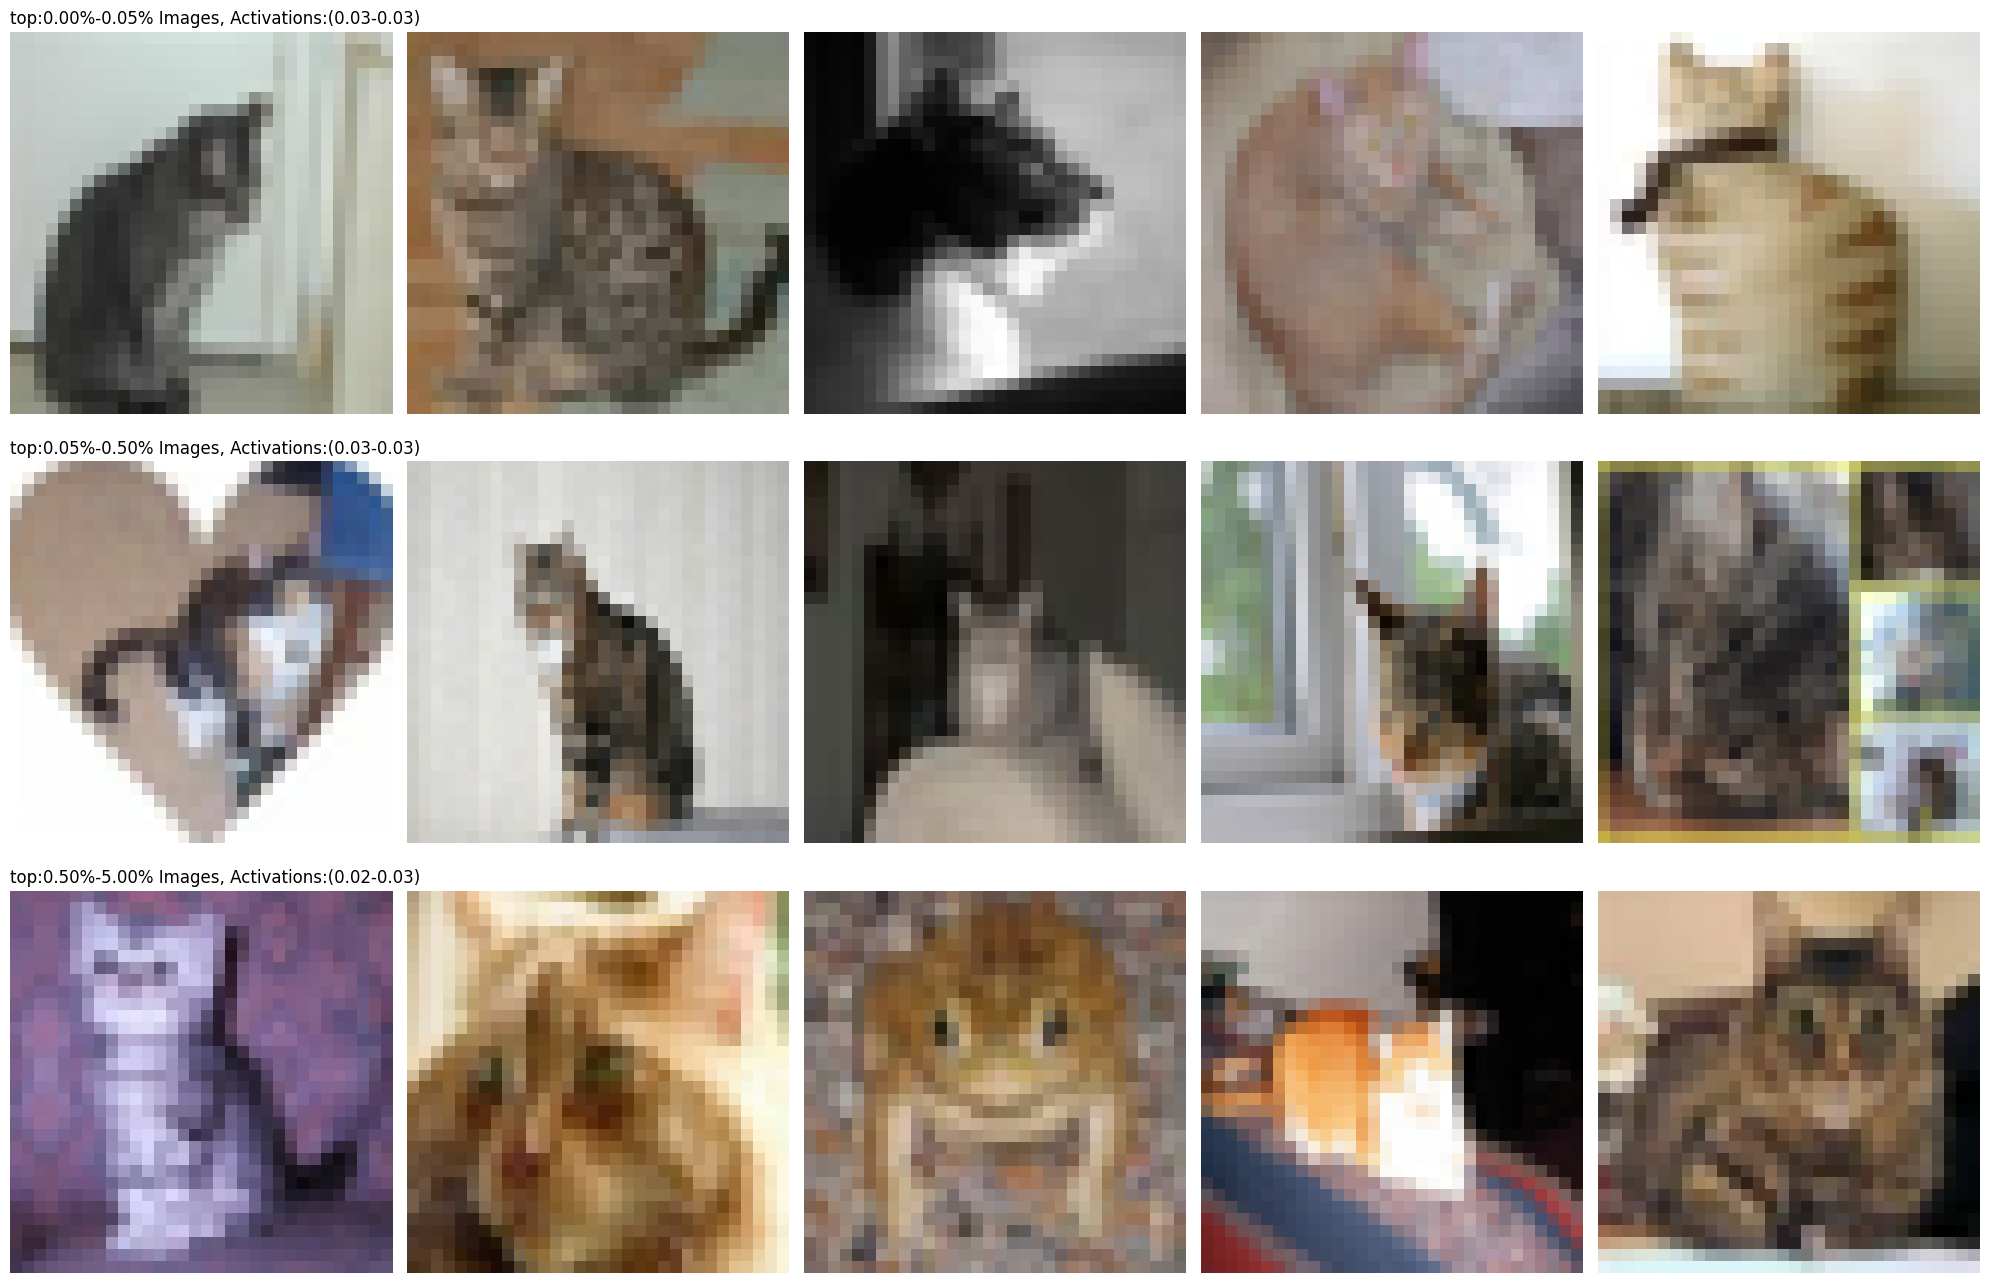

Neuron 12 - a dog bed


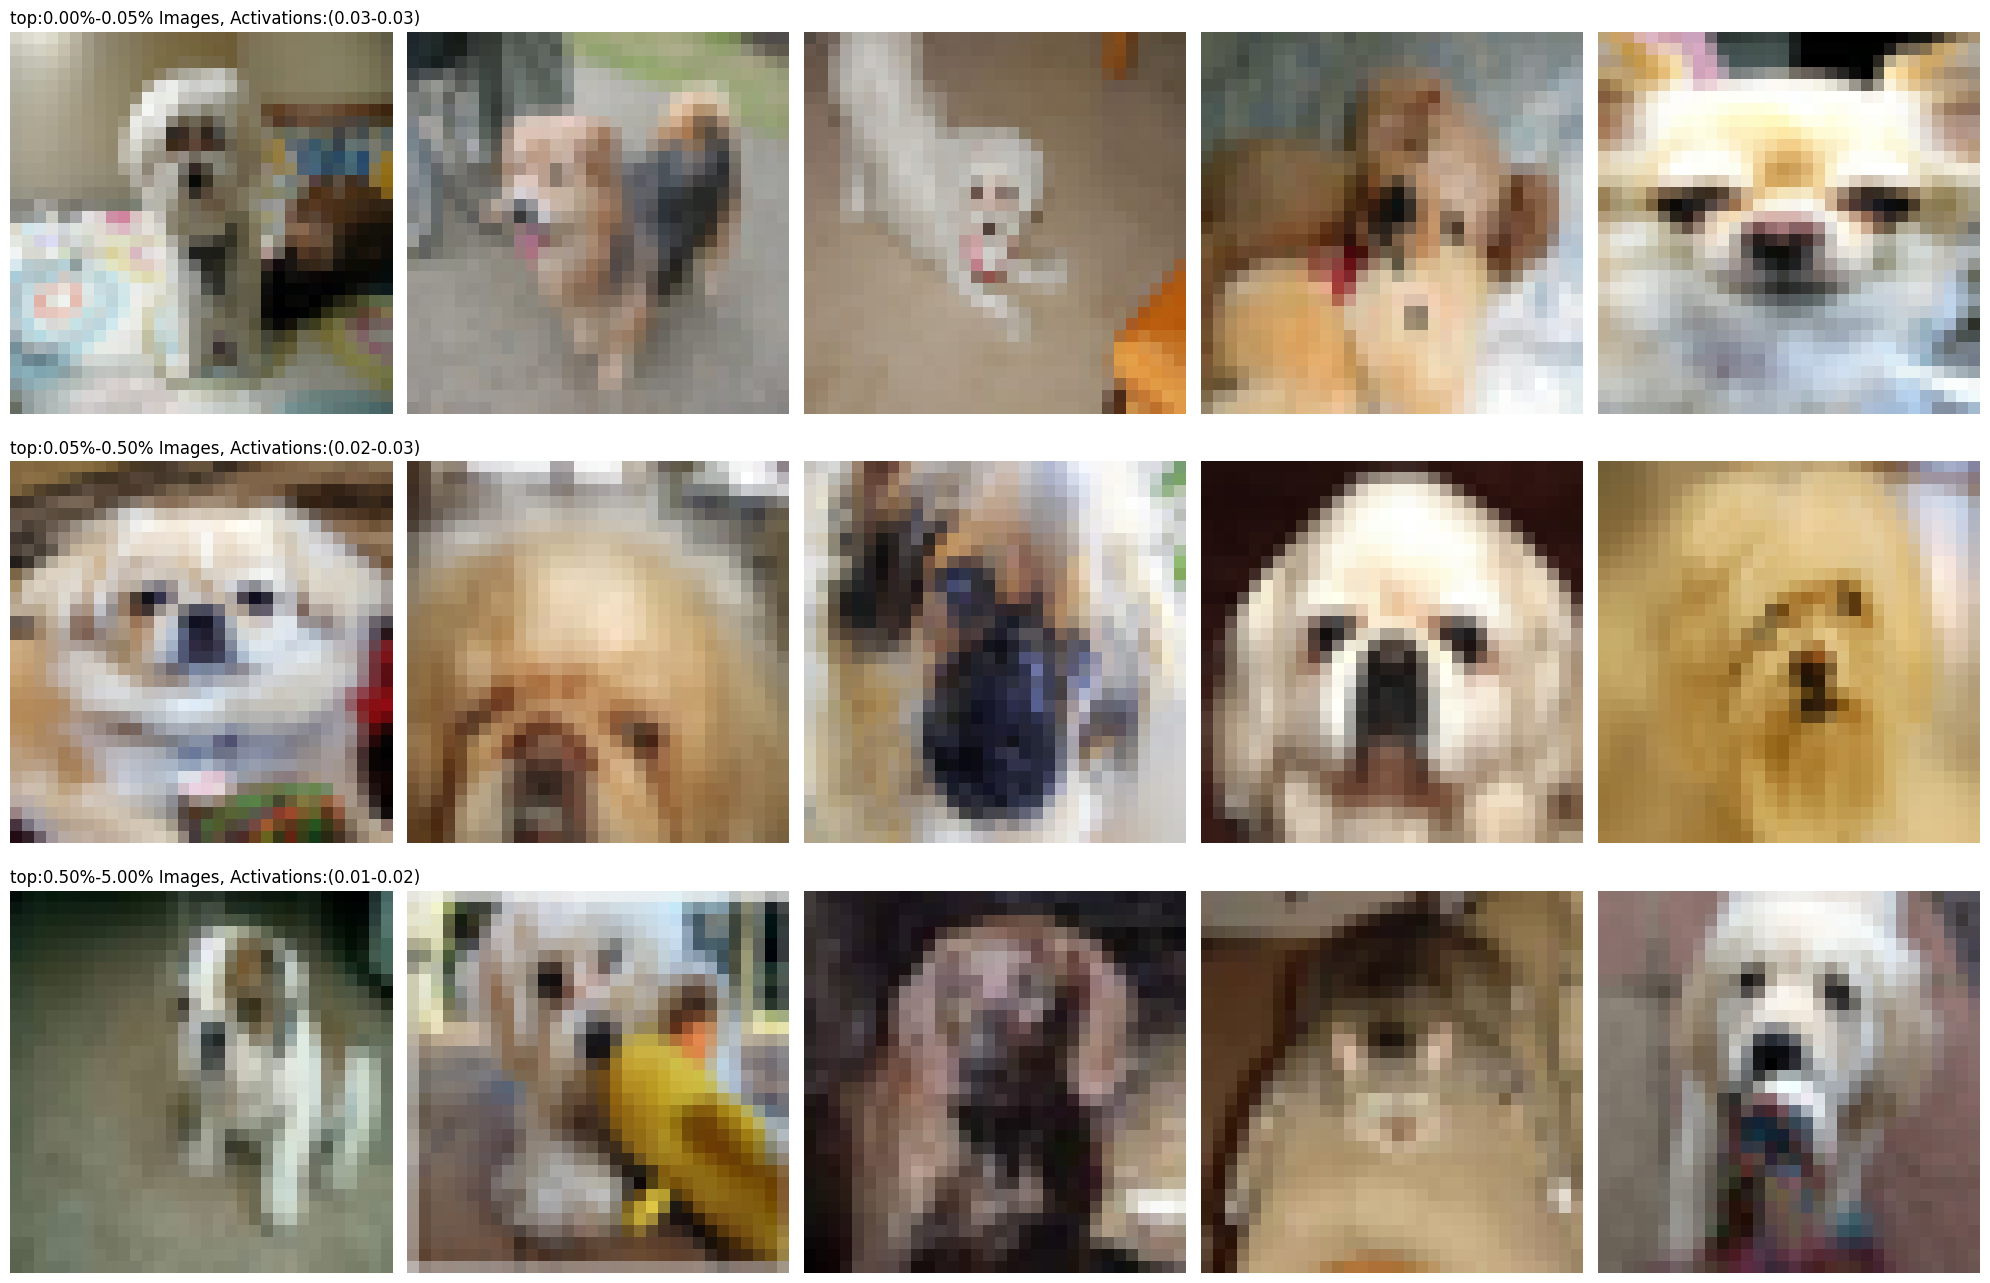

Neuron 13 - a pet food dish


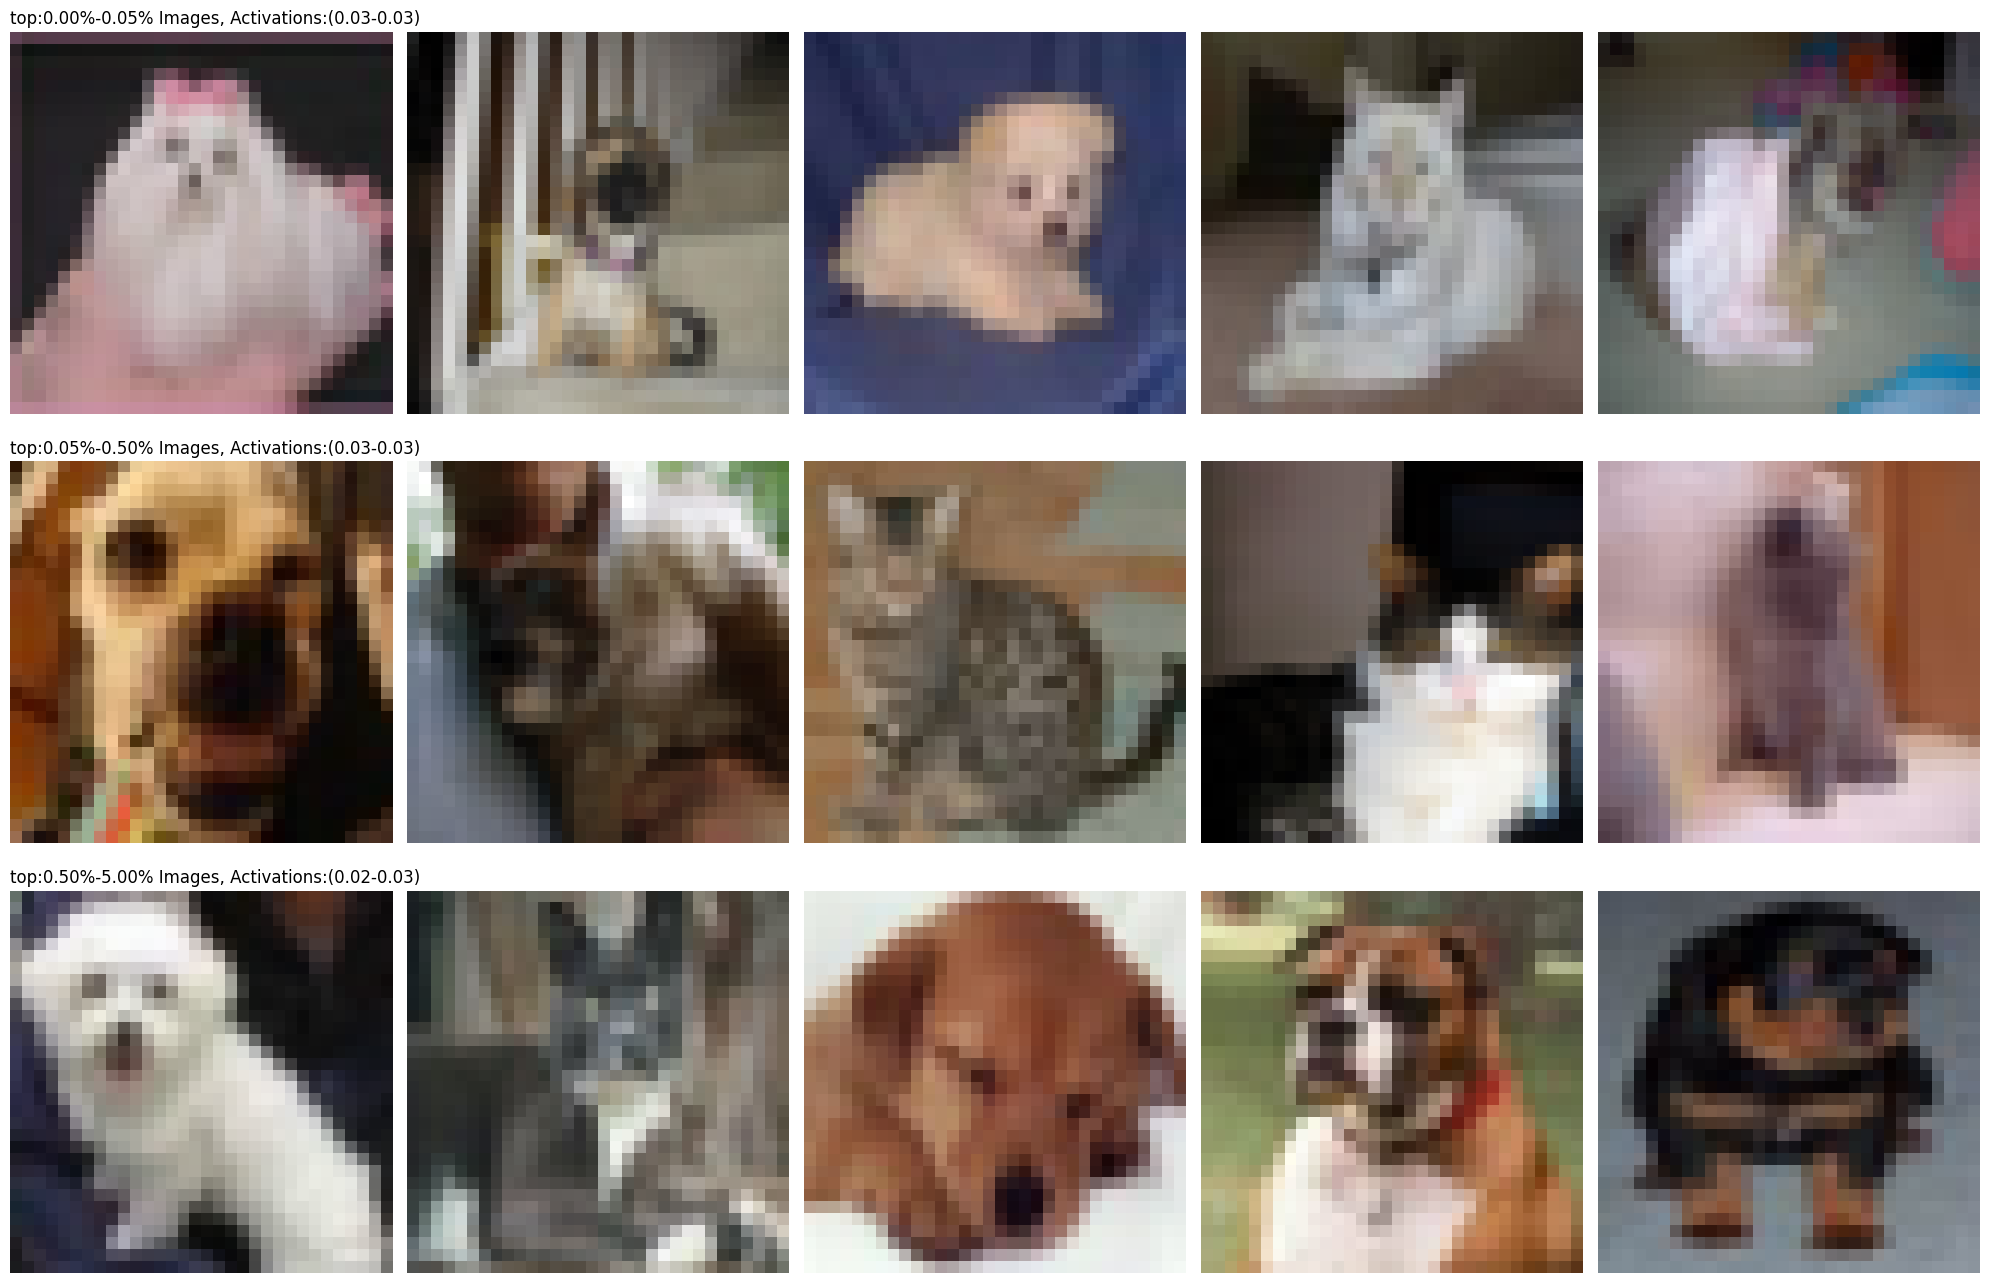

Neuron 14 - a pet toy


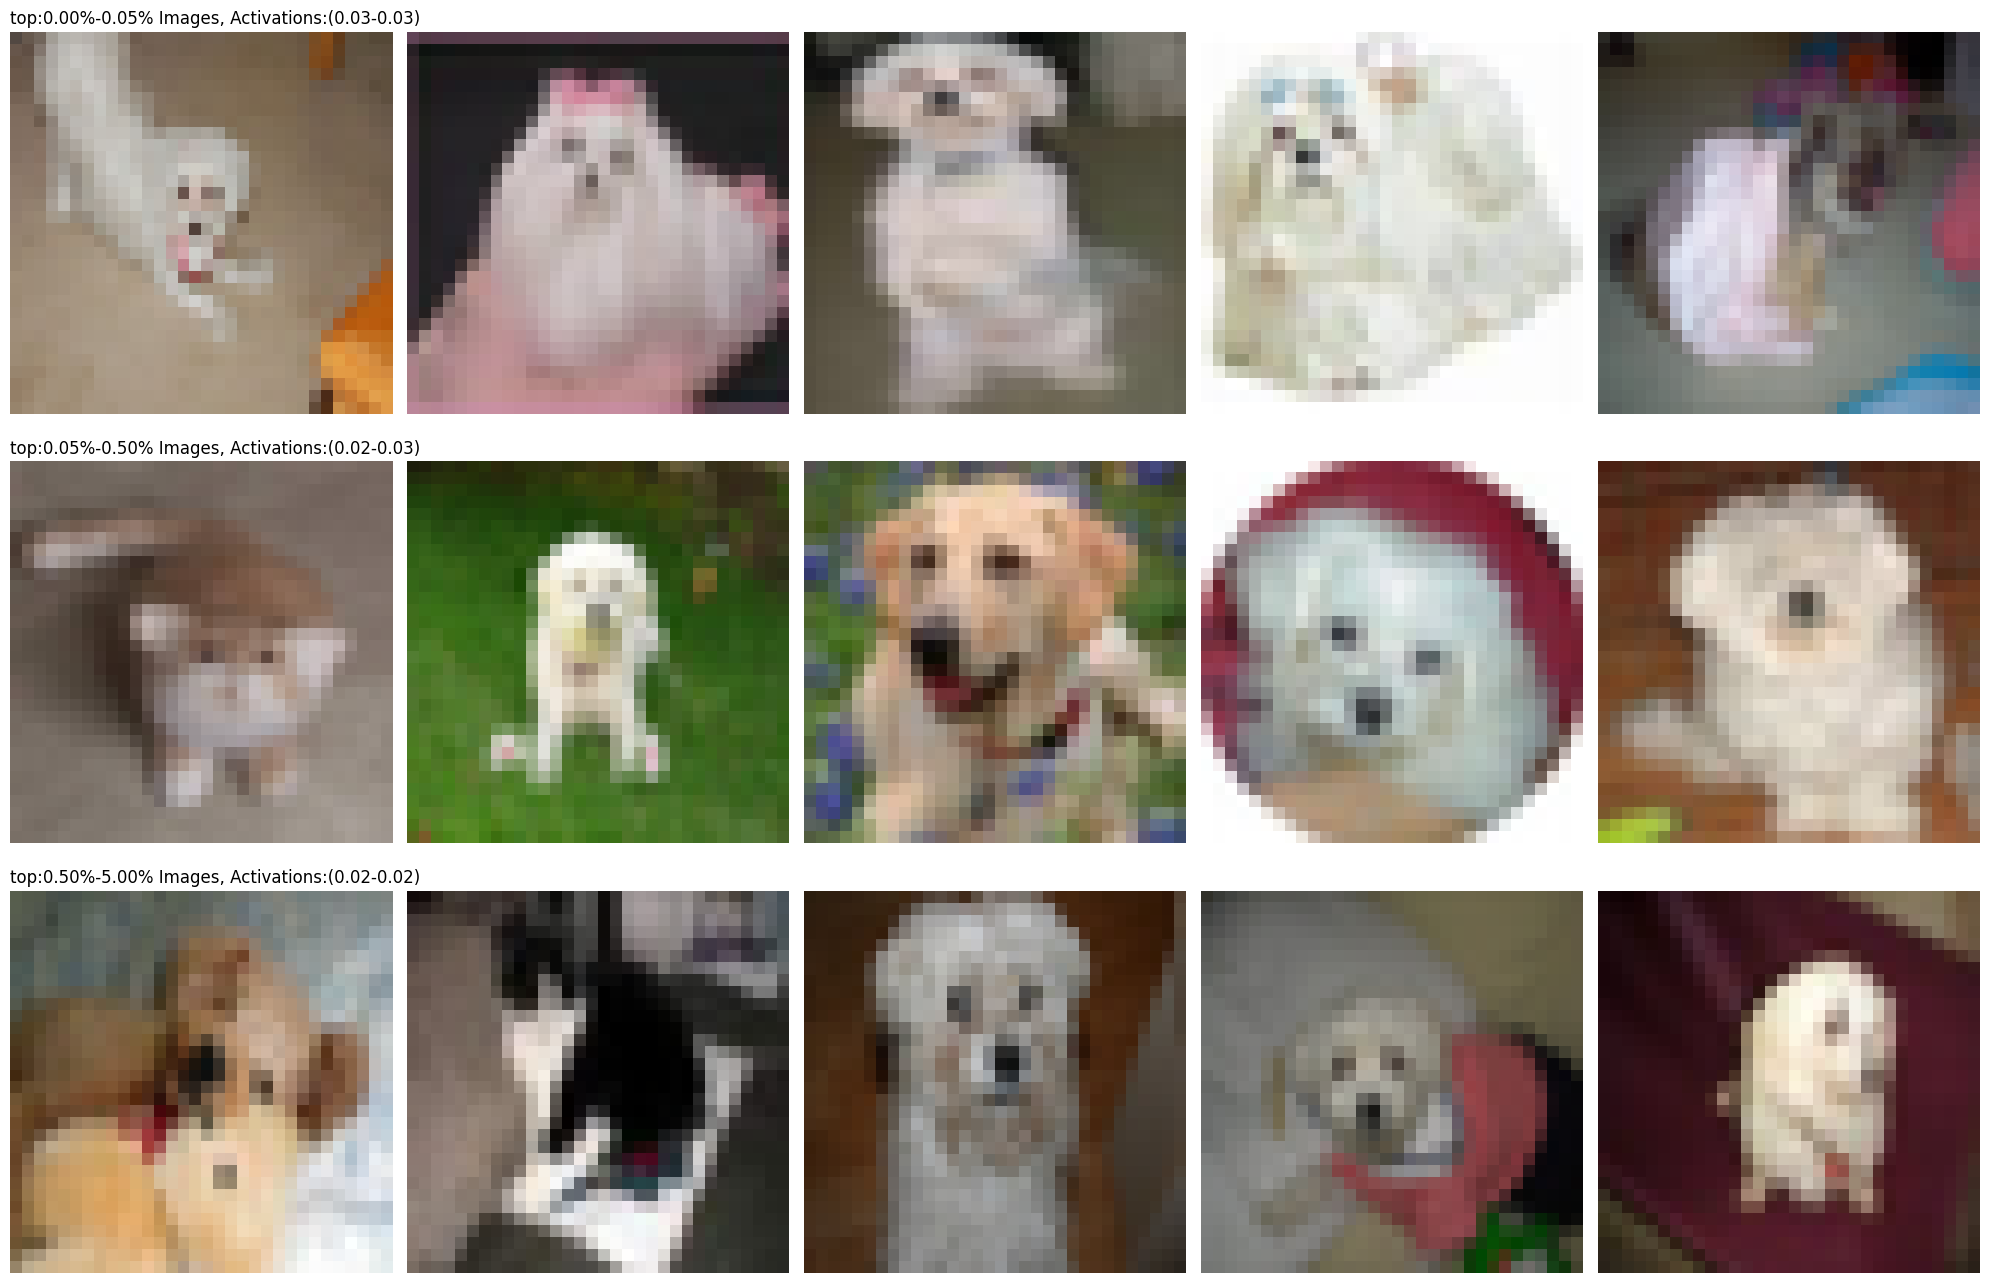

Neuron 15 - a collar


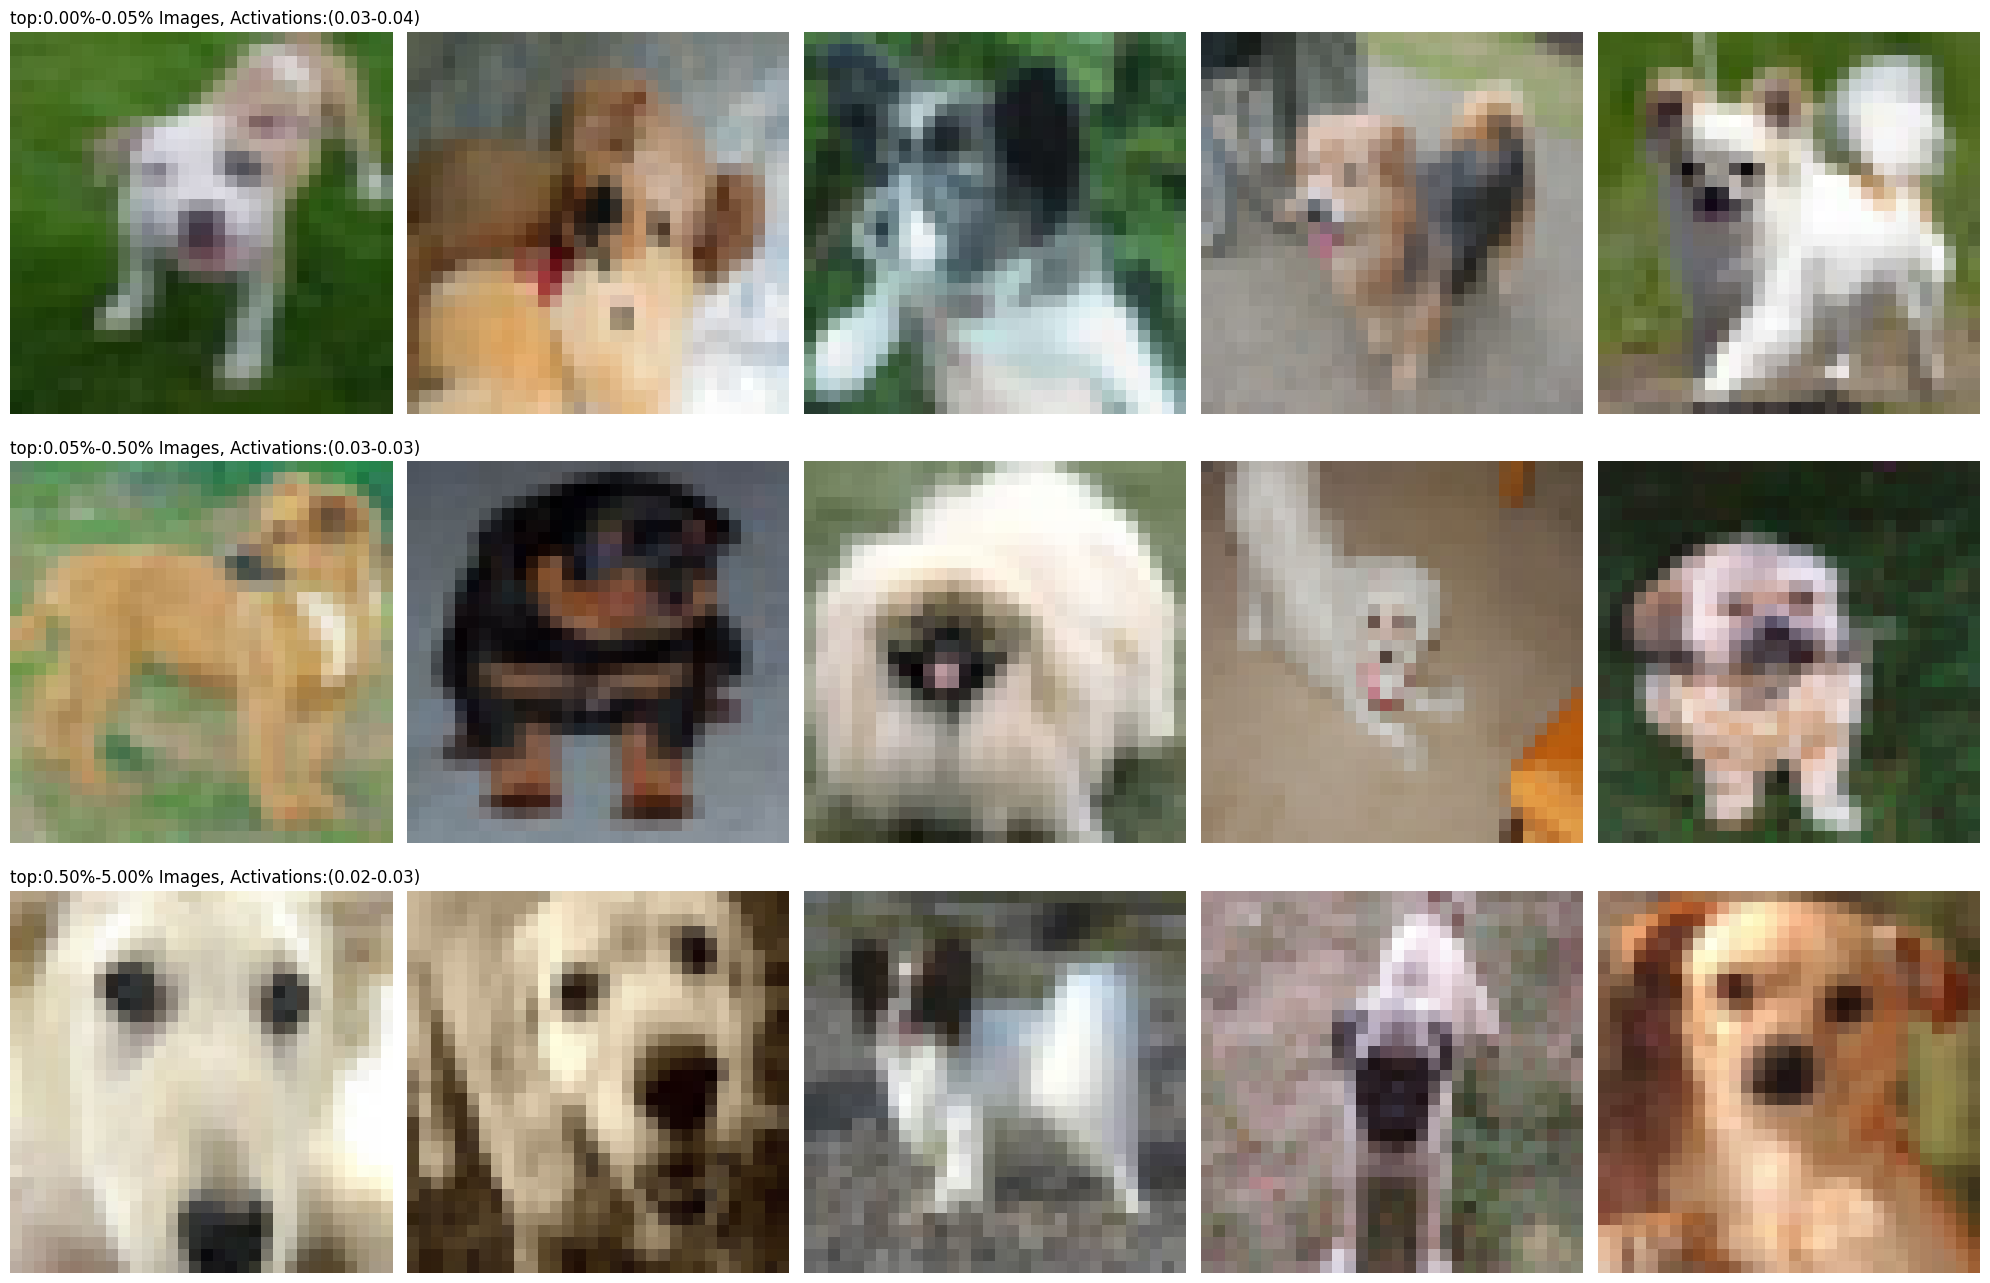

Neuron 16 - a crew


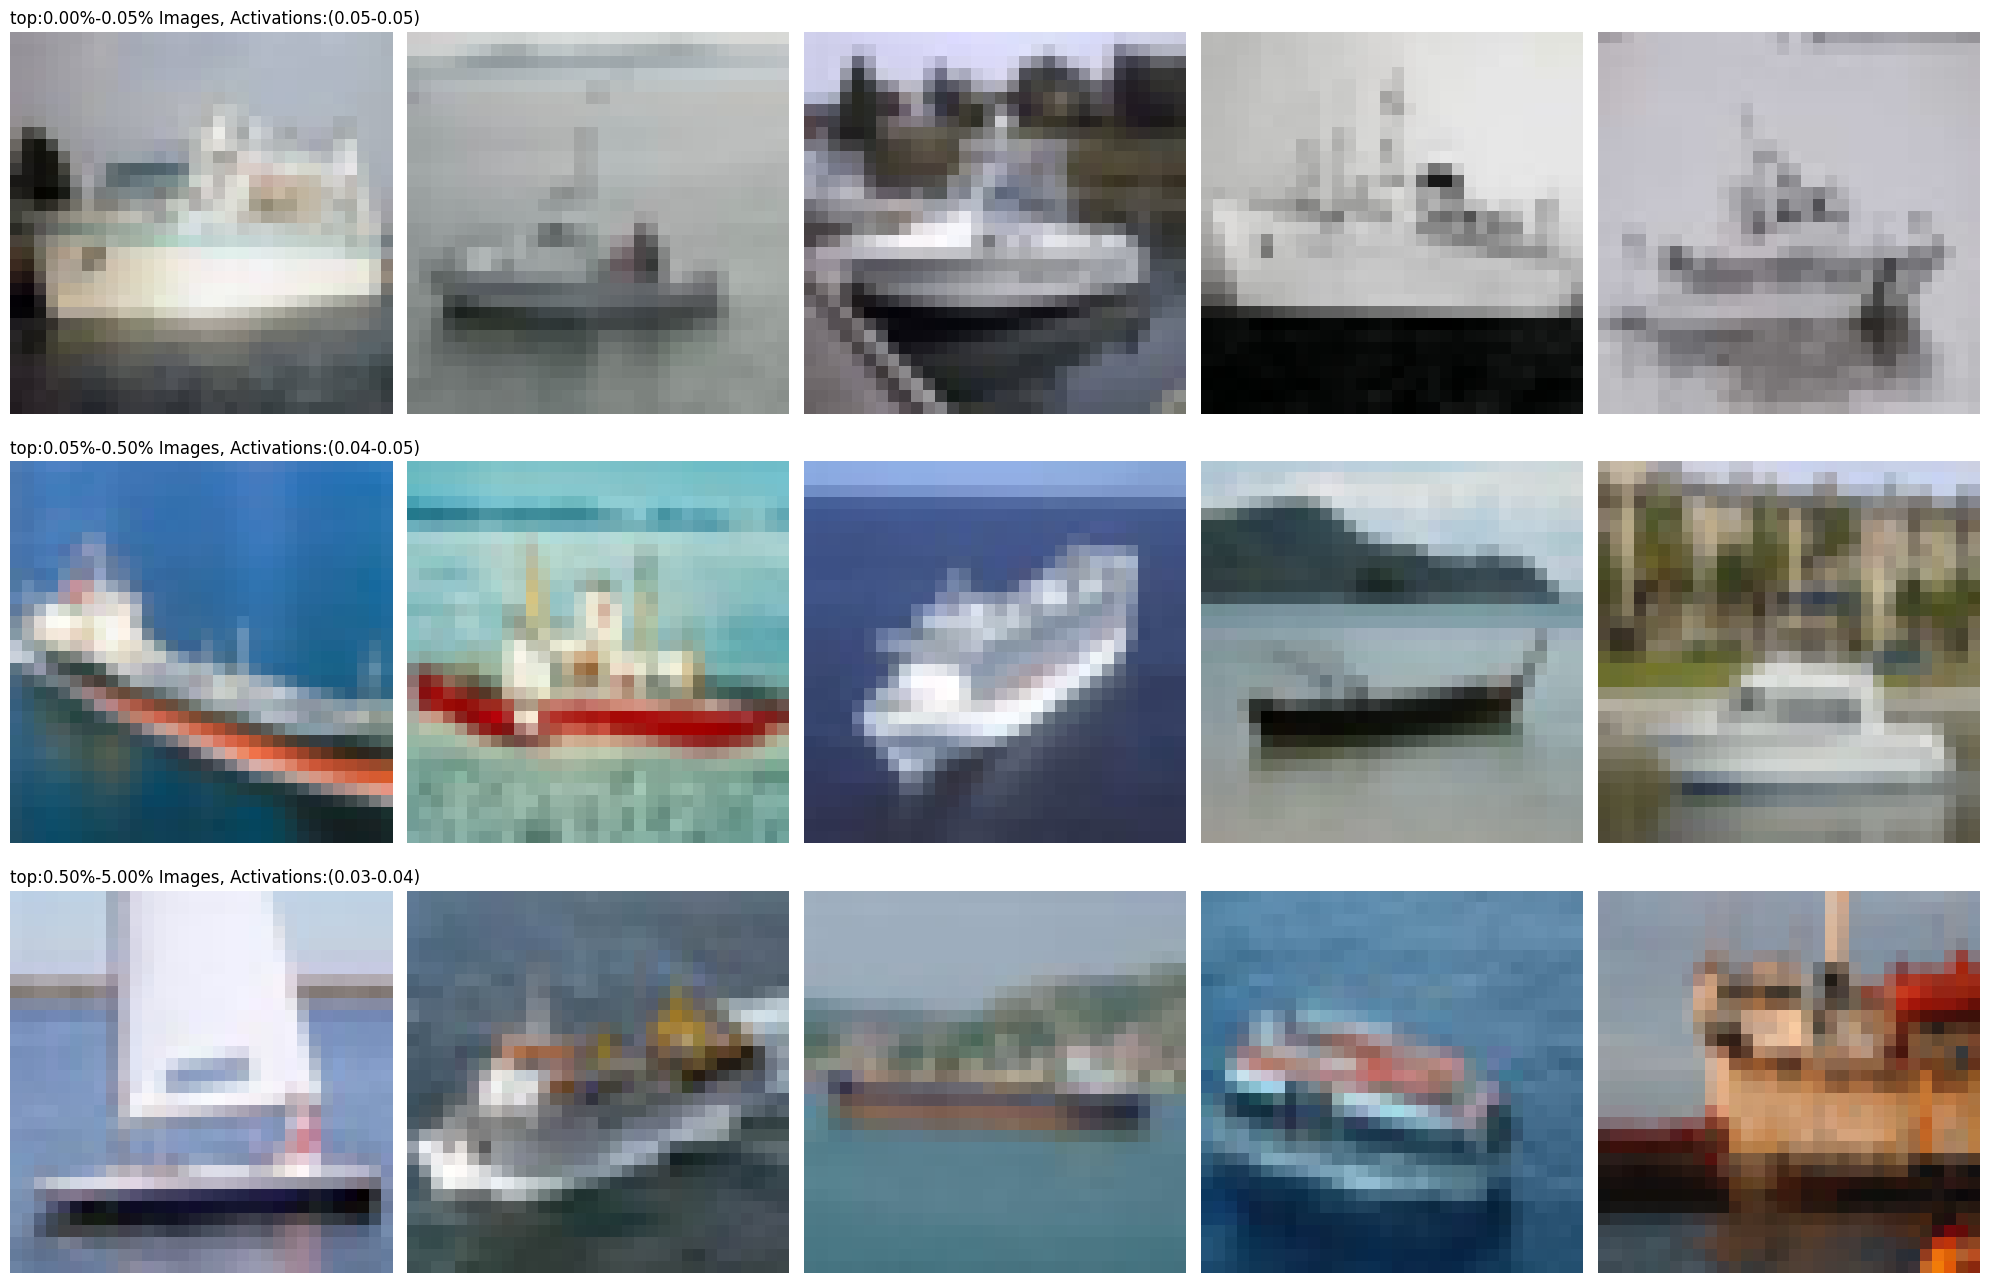

Neuron 17 - a dashboard


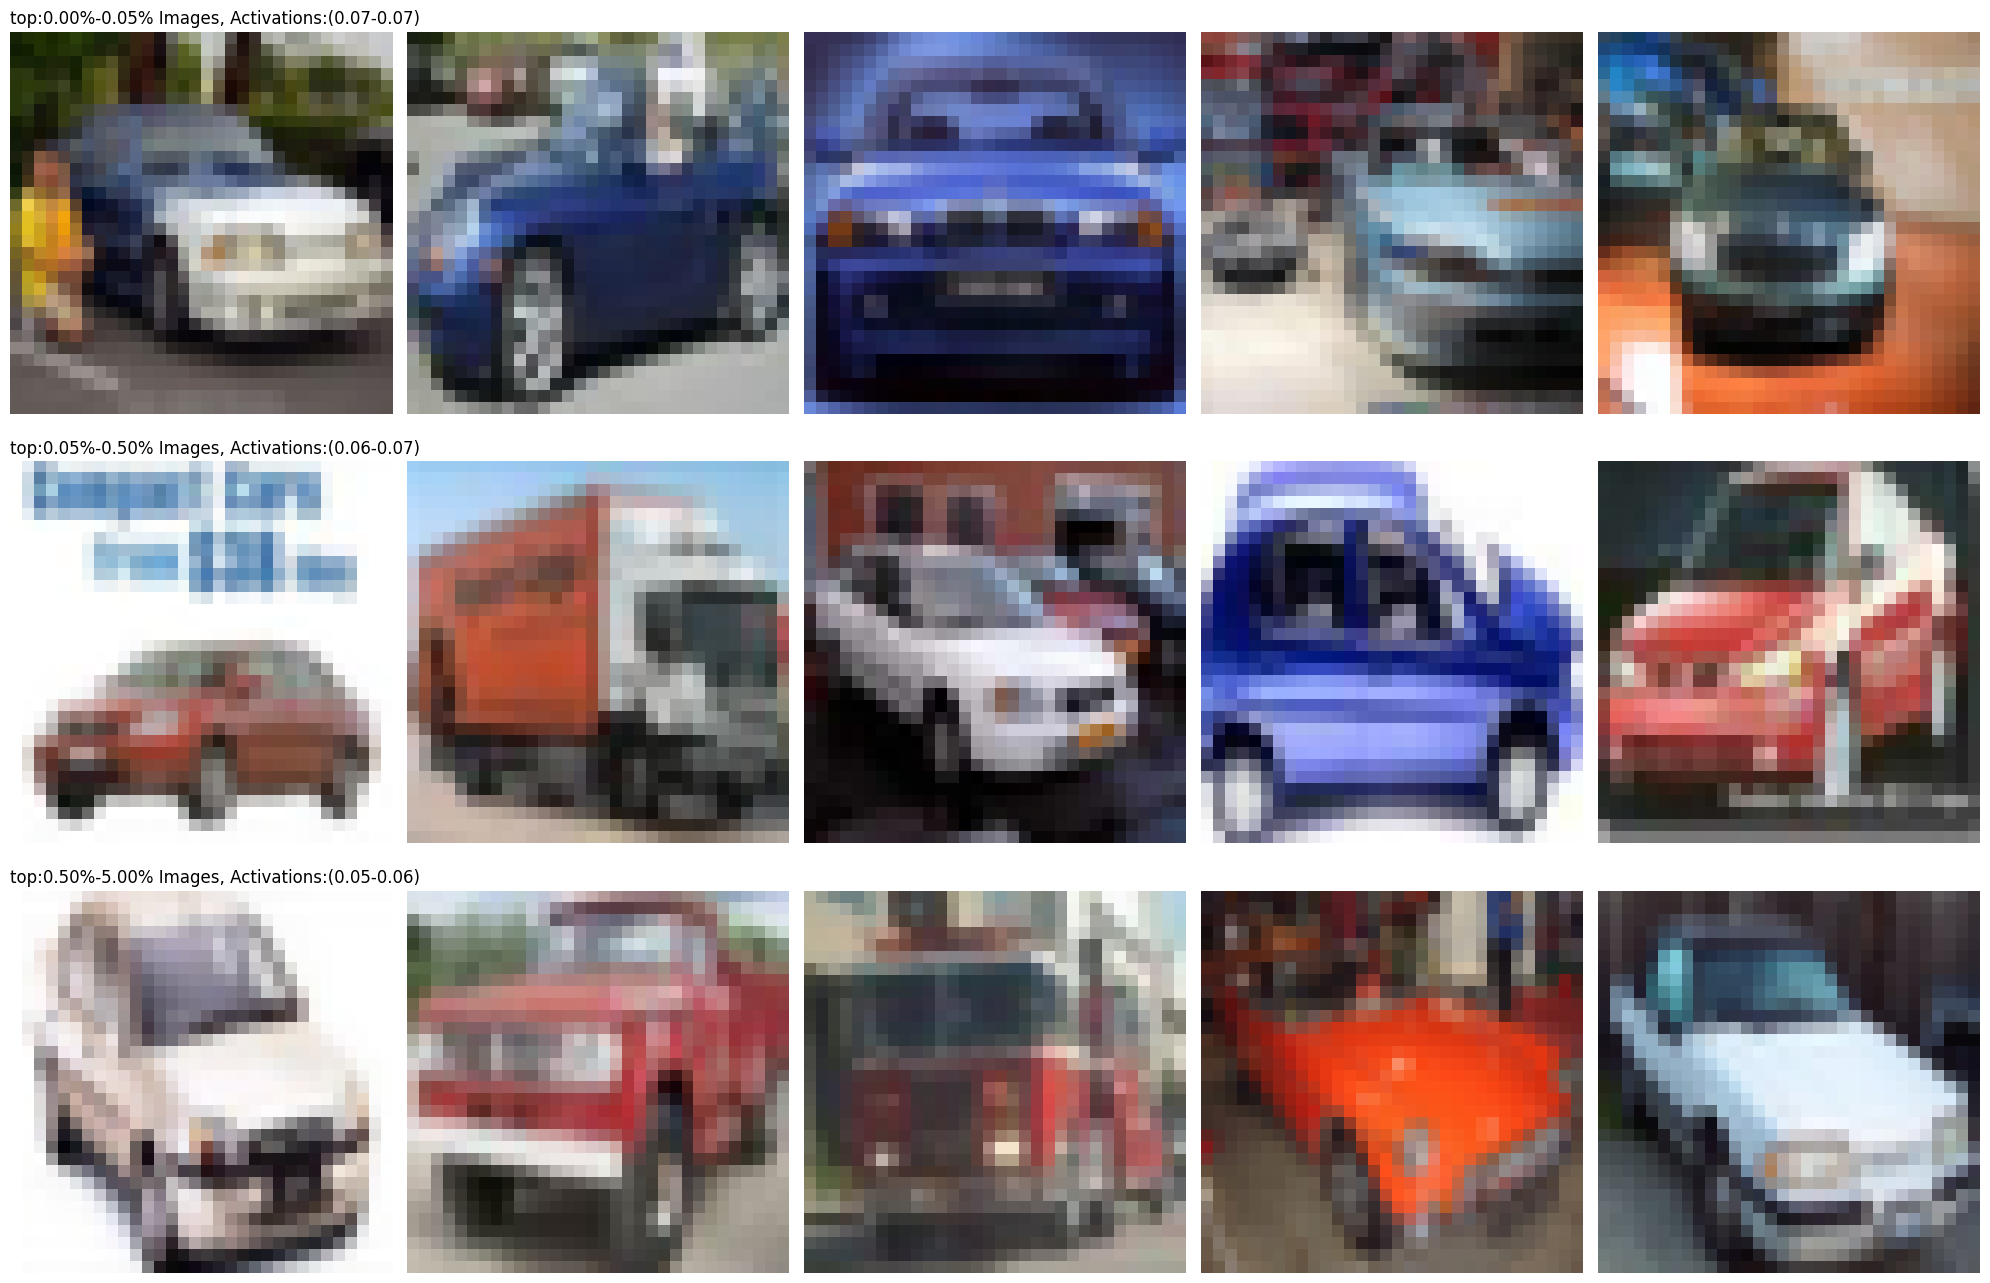

Neuron 18 - a deck


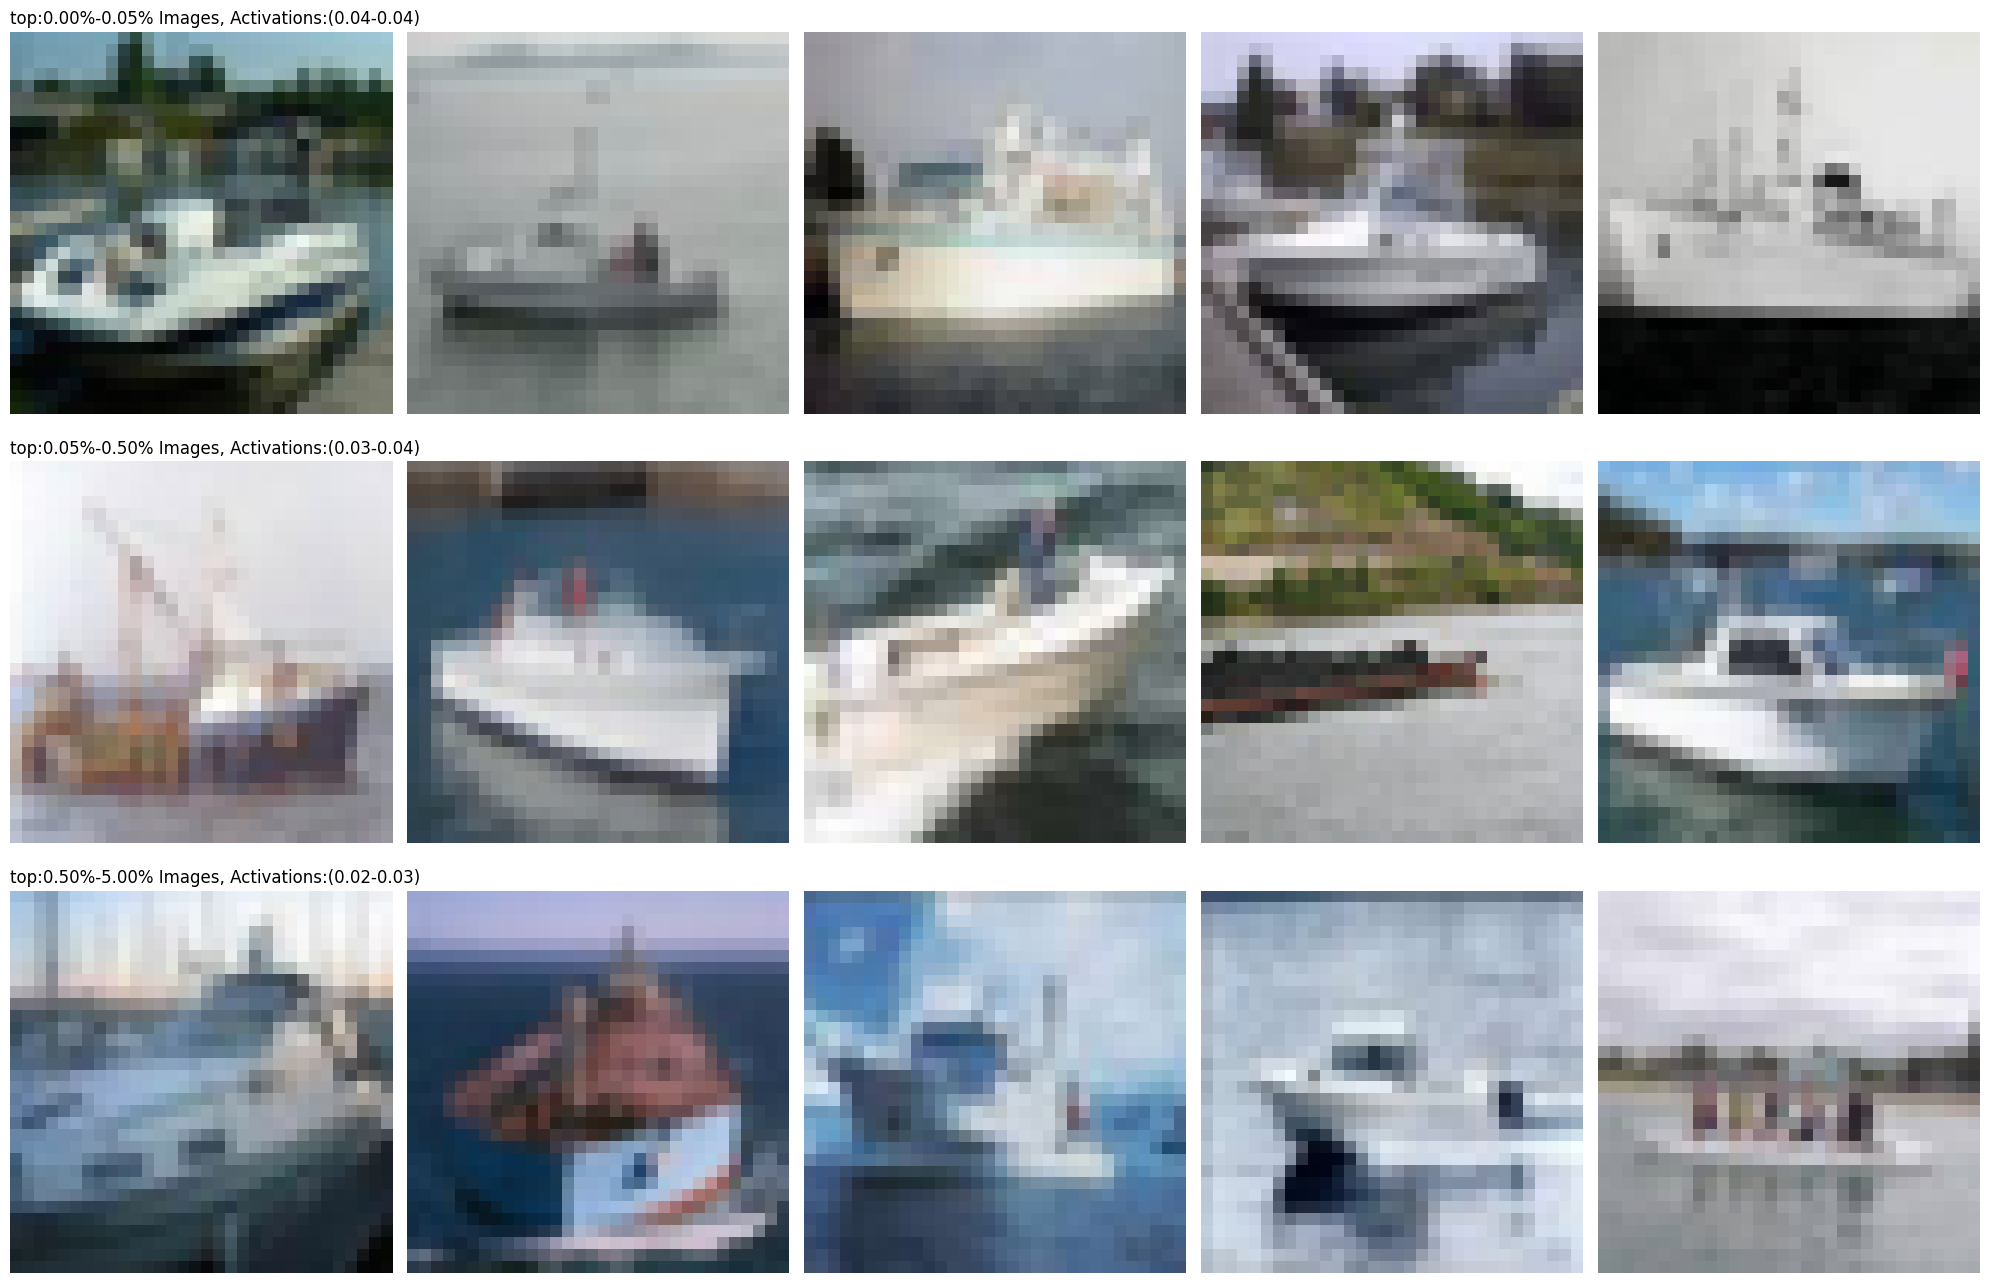

Neuron 19 - a deer stand


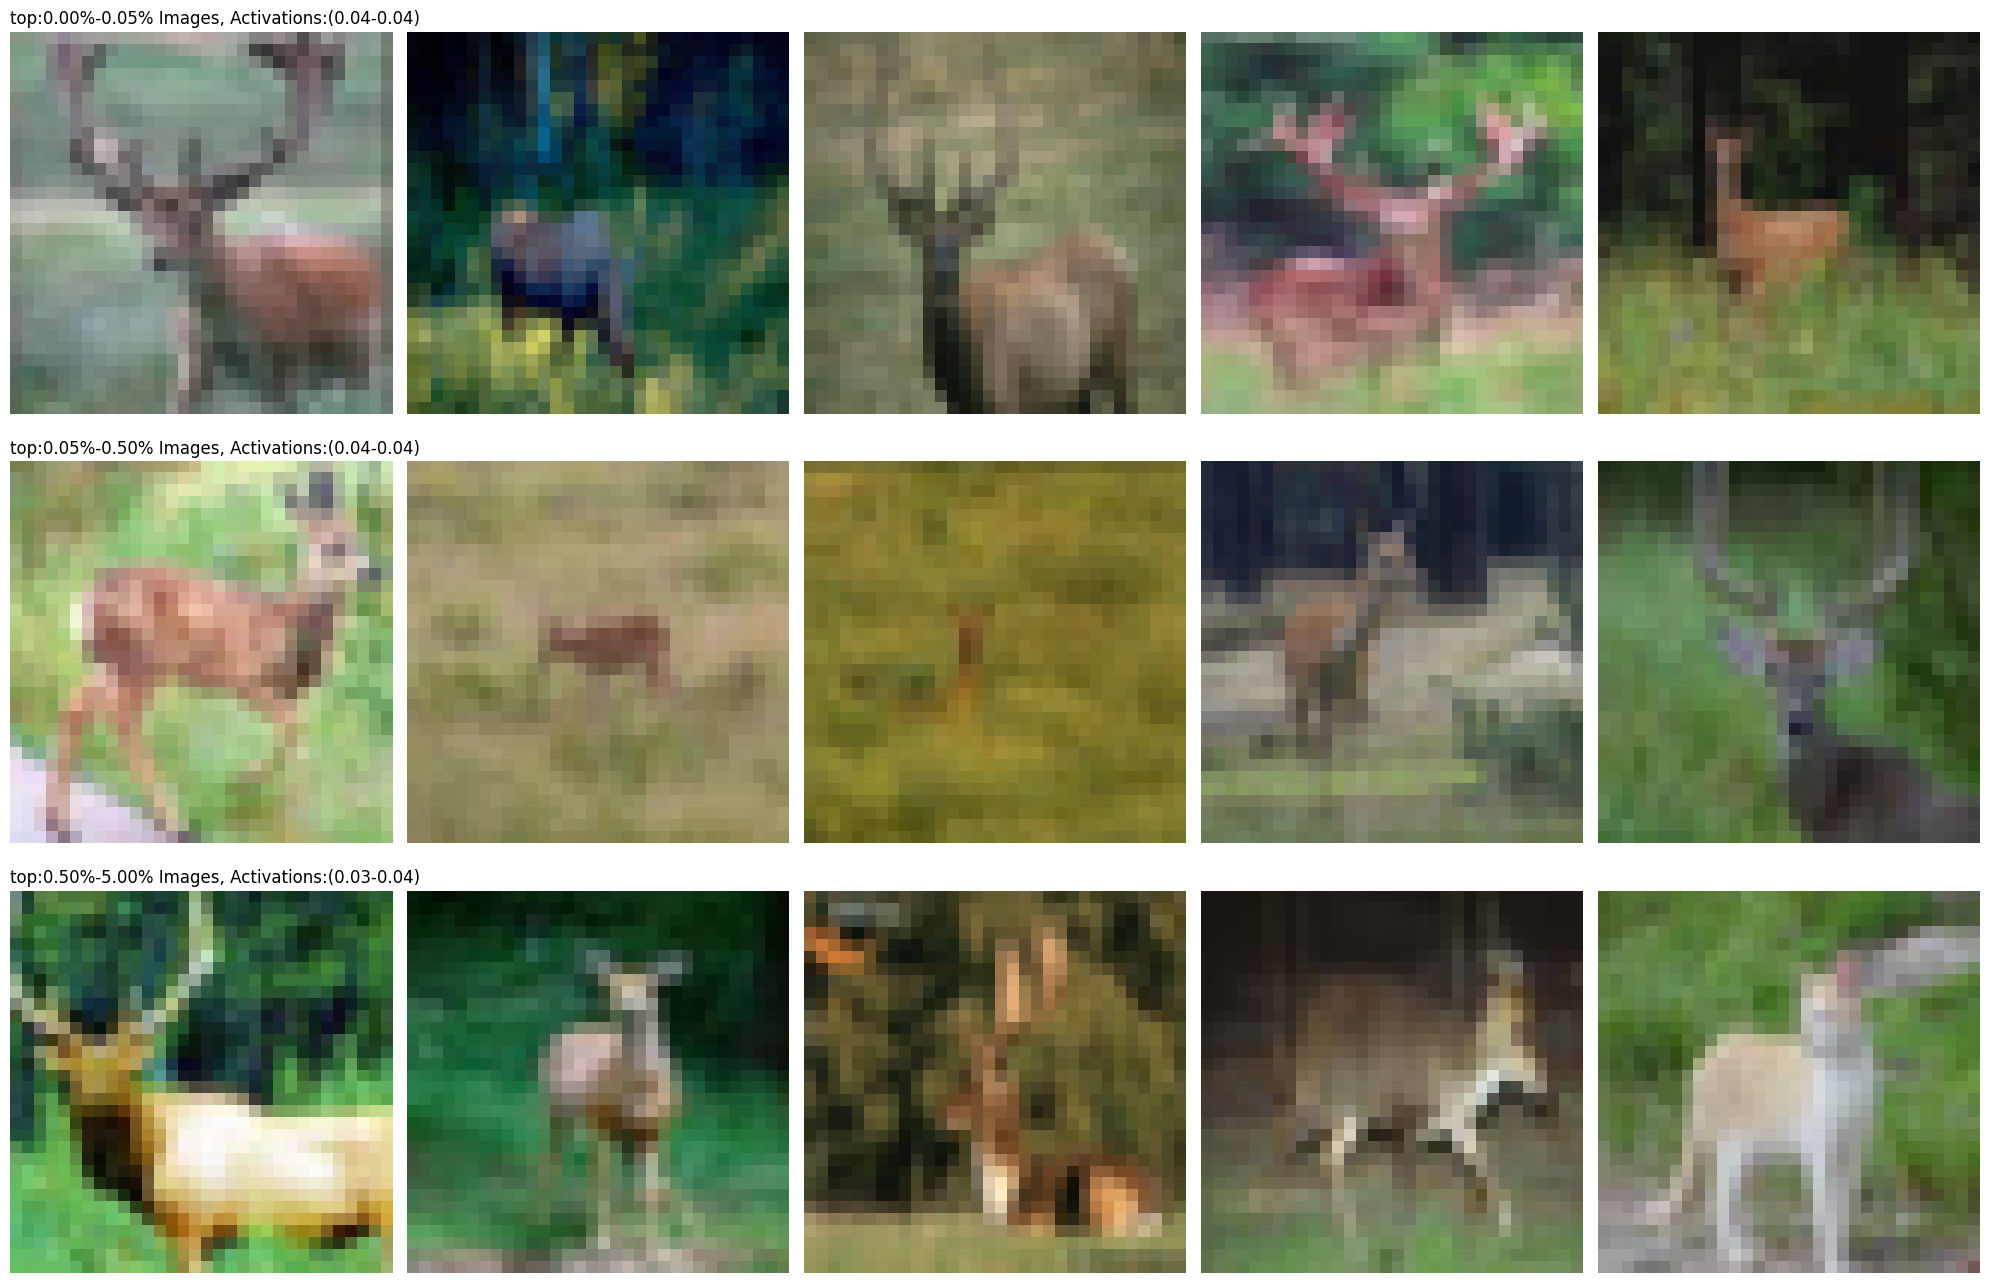

In [29]:
all_activations = le.save_summary_activations(model, dataset, device, target_layer, batch_size, save_path, pool_mode="avg")
for i in target_neurons:
    target_neuron=i
    summary_activations = all_activations[:, target_neuron]
    sorted_act_vals, sorted_act_ids = torch.sort(summary_activations, descending=True)

    explanations = {"clip_dissect":None, "le_label":None, "le_siglip":None} 

    for method in explanations:
        try:
            explanation_path = "results/{}_{}_{}.csv".format(method,target_name, target_layer)
            df = pd.read_csv(explanation_path)
            if method.startswith("le_"):
                explanations[method] = linear_to_str(df, target_neuron)
            else:
                explanations[method] = df[df["unit"]==target_neuron]["description"].iloc[0]
        except(FileNotFoundError):
            explanations[method] = "N/A"

    print("Neuron {} - {}".format(int(target_neuron),true_concepts[i]))
    for i, method in enumerate(explanations):
        if explanations[method] != "N/A":
            method_name = nice_names[method]
            explanation = explanations[method]
            wrapped_explanation = wrap_text(explanation, max_width=80 - len(method_name) - 2)  # -2 for ": "
            explanation_lines = wrapped_explanation.split('\n')
            print(f"{method_name}: {explanation_lines[0]}")
            for line in explanation_lines[1:]:
                print(line)

    nums = [0, 5, 50, 500]
    n_images = 5

    # Calculate total number of rows needed
    total_rows = sum([math.ceil(min(n_images, num - prev_num) / 5) for prev_num, num in zip(nums[:-1], nums[1:])])

    fig, ax = plt.subplots(nrows=total_rows, ncols=5, figsize=(4*5, 4.4*total_rows))

    row_index = 0
    for i, num in enumerate(nums[1:]):
        prev_num = nums[i]
        available_images = num - prev_num
        images_to_show = min(n_images, available_images)

        rows_needed = math.ceil(images_to_show / 5)

        ax[row_index, 0].set_title("top:{:.2f}%-{:.2f}% Images, Activations:({:.2f}-{:.2f})".format(
            prev_num/len(summary_activations)*100,
            num/len(sorted_act_ids)*100,
            sorted_act_vals[num], sorted_act_vals[prev_num]),
            loc="left")

        torch.manual_seed(42)  # or any other fixed number
        perm = torch.randperm(available_images)
        to_show = sorted_act_ids[prev_num:num][perm[:images_to_show]]

        for j in range(images_to_show):
            row = row_index + j // 5
            col = j % 5
            plot_images([to_show[j]], axs=[ax[row, col]])

        # Hide unused axes
        for j in range(images_to_show, rows_needed * 5):
            row = row_index + j // 5
            col = j % 5
            ax[row, col].axis('off')

        row_index += rows_needed

#     # Remove any unused subplots
#     for i in range(row_index, total_rows):
#         for j in range(5):
#             fig.delaxes(ax[i, j])

    plt.tight_layout()
    plt.show()


## Saliency map

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_map(model, x, neuron_idx, requires_grad=True):
    """
    Compute saliency map for a specific neuron in proj_layer for a single input image.
    
    Args:
        model (CBM_model): The CBM model
        x (torch.Tensor): Single input image tensor of shape [channels, height, width]
        neuron_idx (int): Index of the neuron in proj_layer to visualize
        requires_grad (bool): Whether to compute gradients for the input
    
    Returns:
        numpy.ndarray: Saliency map for the specified neuron
    """
    # Ensure the model is in eval mode
    model.eval()
    
    # Create a copy of the input that requires gradient
    if requires_grad:
        x = x.clone().detach().requires_grad_(True)
    
    # Add batch dimension
    x_batch = x.unsqueeze(0)  # Shape becomes [1, channels, height, width]
    
    # Forward pass through backbone and proj_layer
    features = model.backbone(x_batch)
    features_flat = torch.flatten(features, 1)
    proj_output = model.proj_layer(features_flat)
    
    # Get the output for the specified neuron
    neuron_output = proj_output[0, neuron_idx]  # Take first (only) element since we have batch size 1
    
    # Compute gradients
    neuron_output.backward()
    
    # Get gradients with respect to input
    gradients = x.grad.detach()
    
    # Compute saliency map (take absolute value and max across channels)
    saliency_map = torch.max(torch.abs(gradients), dim=0)[0]
    
    # Convert to numpy and normalize to [0, 1]
    saliency_map = saliency_map.cpu().numpy()
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)
    
    return saliency_map

def visualize_saliency_map(model, x, neuron_idx, normalize_input=True):
    """
    Visualize the saliency map alongside the original image.
    
    Args:
        model (CBM_model): The CBM model
        x (torch.Tensor): Single input image tensor of shape [channels, height, width]
        neuron_idx (int): Index of the neuron in proj_layer to visualize
        normalize_input (bool): Whether to normalize the input image for visualization
    """
    # Compute saliency map
    saliency_map = compute_saliency_map(model, x, neuron_idx)
    
    # Convert input image to numpy and move to CPU
    img = x.detach().cpu().numpy()
    
    # Move channels to last dimension and normalize if needed
    img = np.transpose(img, (1, 2, 0))
    if normalize_input:
        img = (img - img.min()) / (img.max() - img.min())
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot original image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Plot saliency map
    saliency_plot = ax2.imshow(saliency_map, cmap='hot')
    ax2.set_title(f'Saliency Map (Neuron {neuron_idx}:{concepts[neuron_idx]})')
    ax2.axis('off')
    
    # Add colorbar
    plt.colorbar(saliency_plot, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Example usage:
"""
# Assuming you have your model and input image ready:
model = CBM_model(...)  # Your model initialization
model.eval()

# Prepare single input image (should be properly preprocessed and on the correct device)
x = ...  # Your input tensor of shape [channels, height, width]

# Visualize saliency map for neuron 0 in proj_layer
visualize_saliency_map(model, x, neuron_idx=0)
"""

'\n# Assuming you have your model and input image ready:\nmodel = CBM_model(...)  # Your model initialization\nmodel.eval()\n\n# Prepare single input image (should be properly preprocessed and on the correct device)\nx = ...  # Your input tensor of shape [channels, height, width]\n\n# Visualize saliency map for neuron 0 in proj_layer\nvisualize_saliency_map(model, x, neuron_idx=0)\n'

In [59]:
val_data_t[0][0].shape

torch.Size([3, 224, 224])

'a tire'

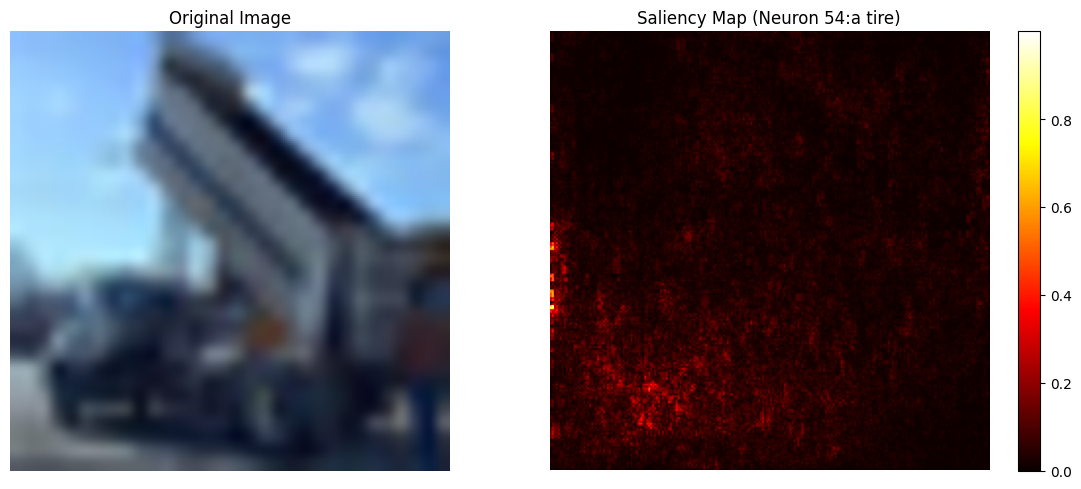

In [62]:
neuron_idx=54
image_id=50
x=val_data_t[image_id][0].cuda()
display(concepts[neuron_idx])
visualize_saliency_map(model, x, neuron_idx=neuron_idx)